# Generate Images Labels

In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine Tune

In [ ]:
# CONFIGURATION
DATA_YAML = "/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml"
PRETRAINED_MODEL = "/content/drive/MyDrive/NeuroKinematic Analyzer/yolo11n-pose.pt"
OUTPUT_DIR = "/content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train"
EPOCHS = 300  # Higher epochs since we’ll be using early stopping
IMAGE_SIZE = 640
DEVICE = 0  # 'cpu' or GPU index
EARLY_STOPPING_PATIENCE = 20  # Stop if no improvement after 20 epochs

In [ ]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.7 MB/s eta 0:00:00


In [ ]:
import optuna
from ultralytics import YOLO
import os

# CONFIGURATION
DATA_YAML = "/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml"
PRETRAINED_MODEL = "/content/drive/MyDrive/NeuroKinematic Analyzer/yolo11n-pose.pt"
BASE_OUTPUT_DIR = "/content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna"
EPOCHS = 300
IMAGE_SIZE = 640
DEVICE = 0
EARLY_STOPPING_PATIENCE = 20

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    lr0 = trial.suggest_float("lr0", 1e-5, 1e-3, log=True)
    batch = trial.suggest_categorical("batch", [8, 16])
    freeze = trial.suggest_categorical("freeze", [0, 10])

    # Experiment naming
    exp_name = f"lr{lr0:.0e}_bs{batch}_frz{freeze}"
    output_dir = os.path.join(BASE_OUTPUT_DIR, exp_name)

    # Load and train model
    model = YOLO(PRETRAINED_MODEL)
    model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        patience=EARLY_STOPPING_PATIENCE,
        val=True,
        lr0=lr0,
        batch=batch,
        freeze=freeze,
        imgsz=IMAGE_SIZE,
        project=BASE_OUTPUT_DIR,
        name=exp_name,
        device=DEVICE,
        pretrained=True,
        save=True,
        resume=False
    )

    # Return mAP@0.5 as the optimization target
    metrics = model.metrics
    # Return mAP@0.5 as the optimization target
    try:
        score = model.metrics.maps[0]  # Pose mAP@0.5
    except Exception as e:
        print("⚠️ Failed to fetch mAP. Error:", e)
        score = 0.0

    print(f"Trial {exp_name} mAP@0.5 = {score}")
    return score

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Report the best hyperparameters
print("✅ Best trial:")
print("  Value:", study.best_value)
print("  Params:", study.best_params)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


[I 2025-05-27 21:59:50,823] A new study created in memory with name: no-name-98667bb6-fc77-4003-b591-813a2c6a26a1


Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003193667628681319, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/NeuroKinematic Analyzer/yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=lr3e-04_bs8_frz0, nbs=64, nms=False, opset=None, optimize

100%|██████████| 755k/755k [00:00<00:00, 108MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n-pose summary: 196 layers, 2,874,462 parameters, 2,874,446 gradients, 7.5 GFLOPs

Transferred 541/541 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 320MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.2±0.1 MB/s, size: 219.3 KB)


train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.5±2.3 ms, read: 0.3±0.1 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003193667628681319' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz0
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.31G     0.5544       1.23     0.1399     0.4279     0.9096         15        640: 100%|██████████| 46/46 [00:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:45<00:00,  7.59s/it]

                   all         91         91      0.999          1      0.995      0.908      0.988      0.989      0.981      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.32G     0.5729      1.255     0.1541     0.4321     0.9226         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]

                   all         91         91      0.997          1      0.995      0.896      0.986      0.989      0.982      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.34G     0.6367      1.629     0.1526      0.463      0.926         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

                   all         91         91      0.999          1      0.995      0.866      0.988      0.989      0.984      0.796



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.34G       0.61      1.785     0.1403     0.4763     0.9276         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         91         91      0.998          1      0.995        0.9      0.987      0.989      0.983       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.34G     0.5557      1.427     0.1436     0.4333     0.9053         15        640: 100%|██████████| 46/46 [00:08<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

                   all         91         91      0.998          1      0.995      0.919      0.987      0.989      0.986      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.35G     0.5752      1.306     0.1489     0.4356     0.9156         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

                   all         91         91      0.999          1      0.995      0.928      0.988      0.989      0.985      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.35G     0.5404      1.222     0.1184     0.4086     0.8916         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all         91         91      0.999          1      0.995      0.947      0.988      0.989      0.985      0.671



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.36G     0.5572      1.604     0.1319     0.4195     0.9012         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all         91         91      0.999          1      0.995      0.897      0.988      0.989      0.982      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.36G     0.5372      1.214     0.1299     0.4034     0.8977         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all         91         91      0.999          1      0.995      0.949      0.999          1      0.995      0.918



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.37G      0.489      1.113     0.1256      0.368     0.8848         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all         91         91      0.998          1      0.995      0.917      0.998          1      0.995      0.885



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.37G     0.4702      1.053     0.1118      0.361     0.8891         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all         91         91      0.999          1      0.995      0.946      0.999          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.37G     0.4829      1.099     0.1178     0.3685     0.8833         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


                   all         91         91      0.999          1      0.995       0.93      0.988      0.989      0.988      0.952

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.37G     0.4963      1.185     0.1214     0.3835     0.8878         15        640: 100%|██████████| 46/46 [00:08<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all         91         91      0.999          1      0.995      0.922      0.977      0.978      0.976        0.9



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.37G     0.4923      1.243     0.1104     0.3872     0.8854         23        640: 100%|██████████| 46/46 [00:10<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.902



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.37G     0.5238      1.269     0.1278     0.3854     0.8881         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all         91         91      0.999          1      0.995      0.921      0.988      0.989      0.985      0.841



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.37G       0.47      1.019     0.1039     0.3526     0.8741         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


                   all         91         91      0.999          1      0.995      0.948      0.999          1      0.995      0.885

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.37G     0.4666      1.044     0.1047     0.3552      0.882         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all         91         91      0.999          1      0.995       0.94      0.988      0.989      0.986      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.37G     0.4648      1.001      0.108     0.3511     0.8679         12        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]

                   all         91         91      0.999          1      0.995      0.932      0.999          1      0.995      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.37G     0.4798      1.231     0.1245     0.3663     0.8901         18        640: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.891



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.37G     0.4437      0.998     0.1072     0.3488     0.8711         15        640: 100%|██████████| 46/46 [00:09<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.37G     0.4398     0.8041    0.09538     0.3372     0.8768         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.37G     0.4088     0.9901    0.09757     0.3234     0.8652         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all         91         91      0.999          1      0.995      0.956      0.988      0.989      0.987      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.39G     0.4456      1.056     0.1009     0.3359     0.8735         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300       1.4G     0.4277     0.9144     0.1098     0.3306     0.8788         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300       1.4G     0.3996     0.8438     0.1053     0.3121     0.8527         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300       1.4G     0.4138     0.8118    0.08775     0.3154     0.8642         20        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300       1.4G     0.3993       0.79     0.0926     0.3074     0.8548         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300       1.4G     0.3993     0.7325    0.08546     0.3099     0.8591         17        640: 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300       1.4G     0.3941     0.8744    0.09366     0.3212     0.8685         15        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300       1.4G     0.4114     0.8611    0.09506     0.3248      0.864         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300       1.4G     0.4163     0.8009    0.08318     0.3413     0.8543         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300       1.4G     0.4008     0.7665    0.08988     0.3212     0.8576         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all         91         91      0.999          1      0.995      0.961      0.988      0.989      0.987      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300       1.4G     0.4318     0.9045    0.09138      0.324     0.8719         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300       1.4G       0.42     0.9572    0.08852     0.3267      0.872         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.983      0.886



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300       1.4G      0.398     0.8651    0.09514     0.3186     0.8689         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

                   all         91         91      0.999          1      0.995      0.966      0.988      0.989      0.982      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300       1.4G     0.3858     0.7565    0.08397     0.3083     0.8582         17        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300       1.4G      0.396     0.8244    0.08165     0.3062     0.8579         14        640: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300       1.4G     0.4005      0.839    0.09003     0.3118     0.8607         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300       1.4G     0.3969     0.7875    0.09216     0.3042     0.8614         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300       1.4G     0.3666     0.7399    0.08195     0.2915      0.849         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300       1.4G     0.3596      0.702    0.07533     0.2827     0.8462         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300       1.4G     0.3868     0.7285     0.0908     0.2913     0.8557         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300       1.4G      0.365     0.6276    0.07663     0.2821     0.8371         17        640: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300       1.4G     0.3558     0.7576    0.08135     0.2831     0.8453         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300       1.4G     0.3623     0.7352    0.07646     0.2785     0.8462         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300       1.4G     0.3628     0.6538    0.08222     0.2841      0.851         12        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300       1.4G     0.3609     0.7078    0.08821     0.2868     0.8495         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.41G     0.3654     0.5787    0.07378     0.2888     0.8576         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.42G     0.3478     0.6085    0.07612     0.2778     0.8514         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.43G     0.3489     0.5654    0.07924     0.2794     0.8496         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.43G     0.3518     0.7172    0.08504     0.2819      0.853         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.43G     0.3769      0.662    0.07867      0.294     0.8565         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.43G      0.363     0.6776     0.0736      0.292     0.8379         11        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.43G     0.3495     0.6649    0.07957     0.2783      0.837         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.43G     0.3681     0.7935    0.08637     0.2904     0.8452         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.43G     0.3556     0.6272    0.06352     0.2831     0.8443         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.43G     0.3714     0.7264     0.0819     0.2876      0.861         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.60it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.44G     0.3492     0.6217    0.07351     0.2862     0.8397         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.46G     0.3612     0.7037    0.07673     0.2814     0.8447         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.46G     0.3689     0.6709    0.07827     0.2876     0.8568         17        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.973



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.46G     0.3518     0.6806    0.07343     0.2788     0.8489         20        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.46G     0.3299      0.653    0.08288      0.274     0.8526         10        640: 100%|██████████| 46/46 [00:10<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.46G     0.3479      0.683     0.0777     0.2796      0.851         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.46G     0.3735     0.8634    0.07893     0.2919     0.8449         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.46G     0.3407     0.7566    0.08178     0.2769     0.8476         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.46G     0.3286     0.7935    0.07921     0.2693      0.841         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.893



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.46G     0.3179     0.5695    0.07172     0.2539     0.8401          9        640: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.46G     0.3043     0.5461    0.06983     0.2546     0.8372         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.46G      0.332     0.4424    0.07164     0.2628     0.8436         18        640: 100%|██████████| 46/46 [00:08<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.46G      0.341     0.5483     0.0685     0.2665     0.8431         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.46G     0.3433     0.5957    0.06621     0.2715     0.8439         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.46G     0.3568     0.5908    0.06769      0.273     0.8456         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.46G     0.3657     0.6104    0.07204     0.2893     0.8435         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.46G     0.3457     0.5847    0.07407     0.2825     0.8489         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.46G     0.3344     0.6543     0.0747     0.2741     0.8568         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.46G      0.333     0.5891    0.06384     0.2696     0.8439         17        640: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.46G      0.335     0.6036    0.07421     0.2791     0.8534         18        640: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.46G     0.3191     0.6098    0.06835     0.2661     0.8412         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.46G     0.3204     0.5875    0.07141     0.2587     0.8294         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.46G     0.3303      0.558    0.07416     0.2643      0.847         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.46G     0.3167     0.5329    0.06734     0.2561     0.8411         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.46G     0.3347     0.6349    0.06929     0.2716     0.8542         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.46G     0.3414     0.6255    0.07199       0.27      0.852         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.46G     0.3392     0.5964    0.06787     0.2663     0.8503         14        640: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.46G     0.3152     0.6491    0.07017     0.2542     0.8352         18        640: 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.46G     0.3342     0.6634    0.06393       0.26     0.8339         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.46G     0.3139     0.5865    0.07042     0.2494     0.8339         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.46G       0.31     0.5756    0.06985     0.2482     0.8469         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.46G     0.2954     0.4993     0.0663     0.2404     0.8326         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.46G     0.2965     0.5279    0.06324     0.2399     0.8357          8        640: 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.46G     0.3082     0.5088    0.05595     0.2401     0.8304         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.46G     0.3053      0.538    0.05943     0.2474      0.837         11        640: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.46G     0.3247     0.4778    0.06917     0.2496     0.8568         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.46G     0.3184     0.5174    0.06863      0.247      0.837         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.46G     0.3045     0.5173    0.06697     0.2499     0.8282         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.46G     0.2844     0.4867    0.06238     0.2318     0.8303         12        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.46G     0.3077     0.5061    0.06116     0.2402     0.8346         12        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.46G     0.3042     0.5541    0.07132     0.2453     0.8369         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.46G     0.2942     0.5458      0.074     0.2408     0.8246         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.46G     0.2988     0.4983    0.06729     0.2361     0.8383         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.46G     0.2958     0.5242    0.06412     0.2395     0.8457         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.46G     0.3004     0.4898    0.06657     0.2377     0.8269         21        640: 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.46G     0.2975     0.4614     0.0566     0.2368      0.837         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.46G     0.2929     0.4355    0.06338     0.2375     0.8257         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.46G     0.2979     0.5322    0.06222     0.2463     0.8325         24        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.46G     0.2957     0.5067    0.07252     0.2411     0.8324         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.46G     0.2902      0.461    0.06245     0.2394     0.8422         12        640: 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.46G     0.2714     0.4525    0.07142     0.2278     0.8318         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.99

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.46G      0.284     0.4819    0.06133     0.2339     0.8445         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.46G     0.2774      0.463    0.06208     0.2258     0.8189         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.46G     0.2861     0.4354    0.05838     0.2306      0.821         11        640: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.46G     0.2781     0.4508    0.06217     0.2279     0.8324         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.46G     0.2784     0.4517     0.0641     0.2251     0.8376         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.46G       0.28     0.5075    0.07694     0.2271       0.83         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.46G     0.2952     0.4263     0.0658     0.2301     0.8388         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.46G     0.3079     0.5303    0.06392     0.2464     0.8415         23        640: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.46G     0.2982     0.4936    0.06678     0.2416     0.8365         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.46G     0.2803     0.5276    0.07122     0.2343     0.8317         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.46G     0.2893     0.4829    0.05525     0.2365     0.8253         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.46G     0.2868     0.4706    0.06417     0.2368     0.8376         20        640: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.46G     0.2828     0.5021    0.05859     0.2307     0.8293         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.46G     0.3014     0.5108    0.07154     0.2423     0.8364         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/300      1.46G     0.3049     0.5649    0.06621     0.2441     0.8336         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/300      1.46G     0.2899     0.4686     0.0589     0.2291     0.8373         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/300      1.46G     0.2948     0.4857    0.06417     0.2392     0.8328         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/300      1.46G     0.3081     0.4944    0.06141     0.2406     0.8378         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/300      1.46G     0.3015      0.483    0.06129     0.2407     0.8357         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/300      1.46G     0.2872     0.4842    0.06562     0.2324     0.8378         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/300      1.46G     0.2841     0.4698    0.06054      0.228     0.8378         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/300      1.46G     0.2753     0.4903     0.0674     0.2269     0.8231         23        640: 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/300      1.46G     0.2888     0.4403    0.06595     0.2321     0.8301         21        640: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/300      1.46G     0.2845     0.4613    0.05975     0.2348     0.8389         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/300      1.46G     0.2772     0.3767    0.05021     0.2259     0.8305         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/300      1.46G     0.2769      0.424    0.05925     0.2309     0.8326         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/300      1.46G     0.2683     0.4717    0.06207     0.2236     0.8346         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/300      1.46G     0.2623     0.4713    0.05853     0.2195     0.8331         12        640: 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/300      1.46G     0.2675     0.4102    0.05639      0.224     0.8258         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/300      1.46G     0.2684     0.4436    0.05814     0.2219     0.8404         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/300      1.46G      0.286     0.4412     0.0627     0.2271     0.8371         18        640: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/300      1.46G     0.2823     0.3719    0.04977     0.2287     0.8272         11        640: 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/300      1.46G     0.2669     0.3503     0.0529     0.2154     0.8287         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/300      1.46G     0.2719     0.4337    0.06037     0.2306     0.8274         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/300      1.46G      0.262     0.4034    0.06023     0.2204       0.82         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/300      1.46G     0.2681     0.4424    0.05383     0.2175     0.8266         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/300      1.46G     0.2488     0.3821    0.05734     0.2061     0.8213         20        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/300      1.46G     0.2538     0.4406    0.05489     0.2084     0.8285         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/300      1.46G     0.2719      0.389    0.06014     0.2192     0.8338         12        640: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/300      1.46G     0.2611     0.3727    0.06099     0.2132     0.8316         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/300      1.46G     0.2666     0.4481    0.05904     0.2152     0.8286         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/300      1.46G      0.265     0.4849    0.06818     0.2241     0.8299         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/300      1.46G      0.248     0.3863    0.05627     0.2101     0.8169         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/300      1.46G     0.2556     0.4502    0.05768      0.208      0.819         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/300      1.46G     0.2559     0.4365    0.05951     0.2162     0.8284         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/300      1.46G     0.2589      0.405     0.0543     0.2129     0.8408         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/300      1.46G     0.2703      0.466    0.05427     0.2149     0.8369         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.989

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/300      1.46G      0.249     0.3713    0.05601     0.2011     0.8277         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/300      1.46G     0.2612     0.3301    0.06012     0.2113     0.8266         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/300      1.46G     0.2569     0.4111    0.06342     0.2132     0.8282         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/300      1.46G     0.2655     0.3855    0.06276     0.2113     0.8376         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/300      1.46G     0.2695     0.4098    0.06026     0.2143     0.8269         10        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/300      1.46G     0.2649     0.4492    0.05513     0.2138     0.8344         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/300      1.46G     0.2466     0.3974    0.04916     0.2045     0.8225         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/300      1.46G     0.2554     0.3905    0.05223     0.2073     0.8279         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 143, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



163 epochs completed in 0.585 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz0/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz0/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz0/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991
Speed: 0.5ms preprocess, 4.7ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz0


[I 2025-05-27 22:35:45,160] Trial 0 finished with value: 1.9760340786838222 and parameters: {'lr0': 0.0003193667628681319, 'batch': 8, 'freeze': 0}. Best is trial 0 with value: 1.9760340786838222.


Trial lr3e-04_bs8_frz0 mAP@0.5 = 1.9760340786838222
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002893710129760979, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/NeuroKinematic Analyzer/yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=lr3e

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±0.5 ms, read: 43.4±36.1 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0002893710129760979' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz10
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300     0.908G     0.5433      1.161     0.1382     0.4035      0.899         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all         91         91      0.999          1      0.995      0.893      0.988      0.989      0.983      0.774



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300     0.908G     0.5906      1.301     0.1512     0.4274      0.924         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all         91         91      0.998          1      0.995      0.869      0.987      0.989      0.983      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300     0.908G     0.5952      1.474     0.1568     0.4471     0.9284         14        640: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all         91         91      0.998          1      0.995      0.903      0.998          1      0.995       0.73



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300     0.908G     0.5678      1.703     0.1511     0.4164     0.9016         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]

                   all         91         91      0.998          1      0.995      0.906      0.998          1      0.995      0.708



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300     0.908G     0.5647      1.944     0.1467     0.4473     0.9059         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all         91         91      0.998          1      0.995      0.896      0.987      0.989      0.985      0.607



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300     0.908G     0.5211      1.485     0.1546     0.4198     0.9001         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all         91         91      0.999          1      0.995      0.938      0.999          1      0.995      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300     0.908G     0.5152      1.353     0.1278     0.4073     0.8813         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.954      0.999          1      0.995      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300     0.908G     0.4943      1.191     0.1395     0.3825     0.8897         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all         91         91      0.999          1      0.995      0.953      0.988      0.989      0.984      0.878



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300     0.916G     0.4883      1.045     0.1334     0.3761     0.8842         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all         91         91      0.999          1      0.995      0.931      0.988      0.989      0.986      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300     0.918G     0.4907      1.057     0.1287      0.367     0.8862         19        640: 100%|██████████| 46/46 [00:08<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         91         91      0.999          1      0.995       0.93      0.999          1      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      0.93G     0.4524     0.9612     0.1137     0.3465     0.8766         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all         91         91      0.988          1      0.995      0.936      0.978      0.989      0.985      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300     0.943G     0.4913      1.001     0.1118     0.3631     0.8841         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995      0.912      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300     0.943G     0.4944      1.056     0.1091     0.3776     0.8794         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all         91         91      0.997          1      0.995      0.953      0.997          1      0.995      0.882



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300     0.943G     0.4534     0.9999     0.1112      0.353     0.8741         23        640: 100%|██████████| 46/46 [00:10<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300     0.943G     0.4794     0.9405     0.1218     0.3538     0.8786         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all         91         91      0.998          1      0.995      0.925      0.998          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300     0.943G     0.4666     0.9327     0.1092     0.3499     0.8731         18        640: 100%|██████████| 46/46 [00:09<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300     0.943G     0.4457     0.9401     0.1127     0.3397     0.8765         21        640: 100%|██████████| 46/46 [00:08<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300     0.943G     0.4339     0.9624     0.1109     0.3469     0.8669         12        640: 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

                   all         91         91      0.999          1      0.995      0.942      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300     0.943G     0.4673      1.044     0.1192     0.3622      0.884         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all         91         91      0.999          1      0.995      0.935      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300     0.943G     0.4243     0.7944     0.1039     0.3383     0.8654         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all         91         91      0.999          1      0.995      0.923      0.999          1      0.995      0.883



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300     0.943G     0.4422     0.7351    0.09101      0.339     0.8768         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300     0.943G     0.3993     0.7746    0.09755      0.318     0.8576         14        640: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300     0.943G     0.4178     0.9893    0.09987     0.3318     0.8665         19        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300     0.943G     0.4092      0.857     0.1053     0.3308     0.8752         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

                   all         91         91      0.999          1      0.995      0.964      0.988      0.989      0.989      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300     0.943G      0.373     0.8424     0.1008     0.3032     0.8456         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300     0.943G     0.3807     0.7101    0.08826     0.3039     0.8546         20        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300     0.943G     0.3831     0.7079    0.09213      0.309     0.8489         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300     0.943G     0.3975     0.6835    0.08685     0.3234     0.8617         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300     0.943G     0.3909      0.763    0.08887     0.3124     0.8684         15        640: 100%|██████████| 46/46 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300     0.943G     0.3979     0.8467    0.09349     0.3126     0.8588         20        640: 100%|██████████| 46/46 [00:08<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300     0.943G        0.4      0.886    0.07841     0.3164     0.8495         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300     0.943G     0.3605      0.794    0.08167     0.2879     0.8447         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300     0.943G     0.3574     0.7034    0.08378     0.2848      0.854         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300     0.943G      0.367      0.706    0.08315     0.2949     0.8543         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300     0.943G     0.3668     0.7172    0.08759     0.2958     0.8574         13        640: 100%|██████████| 46/46 [00:08<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300     0.943G     0.3934     0.7215    0.08262     0.3032     0.8577         17        640: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300     0.943G     0.3783     0.7524    0.07572     0.2952     0.8542         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.973



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300     0.943G     0.3616     0.6903    0.08637     0.2866     0.8497         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300     0.943G     0.3747     0.7487    0.08786     0.2943     0.8516         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.975

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300     0.943G     0.3466     0.5915    0.07542      0.282     0.8403         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.989

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300     0.943G     0.3732     0.6108    0.06851     0.2938     0.8463         19        640: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300     0.943G     0.3739     0.6968    0.08939     0.3002     0.8559         16        640: 100%|██████████| 46/46 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300     0.943G       0.36     0.6055    0.07566     0.2929      0.836         17        640: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300     0.943G     0.3497     0.6275    0.08132     0.2927     0.8421         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300     0.943G     0.3757     0.6033    0.07238     0.2933     0.8522         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.953



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300     0.943G     0.3471     0.5891    0.07782     0.2889     0.8498         12        640: 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300     0.943G     0.3506     0.6353    0.08805     0.2856     0.8499         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.981

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300     0.943G     0.3364     0.4986     0.0688     0.2745     0.8509         16        640: 100%|██████████| 46/46 [00:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300     0.943G     0.3372      0.528    0.07155     0.2716     0.8501         19        640: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300     0.943G     0.3382     0.5417    0.07672     0.2717     0.8456         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300     0.943G     0.3538     0.6571    0.08363     0.2813     0.8524         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300     0.943G     0.3177     0.5555    0.07725     0.2646     0.8456         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300     0.943G     0.3062     0.5387    0.07321     0.2548     0.8261         11        640: 100%|██████████| 46/46 [00:08<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300     0.943G     0.3218      0.563    0.08173     0.2611     0.8294         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300     0.943G     0.3391     0.7515    0.08764     0.2697     0.8327         14        640: 100%|██████████| 46/46 [00:09<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.982      0.988      0.989      0.988      0.979


EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

55 epochs completed in 0.184 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz10/weights/last.pt, 6.0MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz10/weights/best.pt, 6.0MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz10/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.985
Speed: 0.7ms preprocess, 6.6ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr3e-04_bs8_frz10


[I 2025-05-27 22:47:02,775] Trial 1 finished with value: 1.9638340756692816 and parameters: {'lr0': 0.0002893710129760979, 'batch': 8, 'freeze': 10}. Best is trial 0 with value: 1.9760340786838222.


Trial lr3e-04_bs8_frz10 mAP@0.5 = 1.9638340756692816
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00043384922733157017, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/NeuroKinematic Analyzer/yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=lr

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.0±0.6 ms, read: 52.8±26.4 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs16_frz0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00043384922733157017' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs16_frz0
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.58G     0.5821      1.037     0.1376     0.4338     0.9023         42        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         91         91      0.999          1      0.995      0.915      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.58G     0.5326      1.269     0.1463      0.402     0.9128         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.891      0.999          1      0.995      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.58G     0.5521      1.202     0.1519       0.41     0.8956         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.998          1      0.995      0.895      0.998          1      0.995      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.58G     0.5517      1.214     0.1363      0.426     0.9166         42        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         91         91      0.996          1      0.995      0.885      0.985      0.989      0.984      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.58G     0.5832      1.444     0.1468     0.4439     0.9156         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         91         91      0.996          1      0.995      0.928      0.985      0.989      0.984      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.59G     0.5815      1.577     0.1452     0.4377     0.9207         34        640: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.997          1      0.995      0.912      0.986      0.989      0.983      0.669



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300       2.6G     0.5463      1.264     0.1225     0.4012     0.9062         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         91         91      0.994          1      0.995      0.943      0.994          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.62G     0.5132      1.347     0.1368     0.4053     0.9042         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.997          1      0.995       0.92      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.63G     0.5295      1.456     0.1335     0.3931     0.9019         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         91         91      0.998          1      0.995      0.929      0.976      0.978      0.973      0.738



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.65G     0.5224      1.308      0.126     0.3779     0.8977         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91          1      0.999      0.995      0.947          1      0.999      0.995      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.67G     0.4996      1.301     0.1197     0.3702     0.8926         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.998          1      0.995      0.912      0.987      0.989      0.983      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.67G     0.5008      1.111     0.1187      0.382     0.8938         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.67G     0.4808      1.096     0.1136     0.3679     0.8889         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         91         91      0.996          1      0.995      0.924      0.996          1      0.995      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.67G     0.4921     0.9792      0.108     0.3764      0.878         42        640: 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.998          1      0.995      0.924      0.998          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.67G     0.4647     0.9402     0.1051     0.3586     0.8744         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.998          1      0.995      0.937      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.67G     0.4739     0.8579     0.1035     0.3605      0.882         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995      0.928      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.67G      0.496      1.111     0.1068     0.3772     0.8916         24        640: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         91         91      0.999          1      0.995      0.943      0.988      0.989      0.985       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.67G     0.4953      1.211     0.1098     0.3778     0.8924         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         91         91      0.998          1      0.995      0.944      0.987      0.989      0.986      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.67G     0.4542      1.106     0.1124     0.3653     0.8734         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.994          1      0.995      0.949      0.984      0.989      0.977      0.896



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.67G     0.4236     0.9478    0.09071     0.3274     0.8689         24        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         91         91      0.999          1      0.995      0.938      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.67G     0.4294      1.097     0.1056     0.3385     0.8684         23        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.67G     0.4183     0.9239     0.1002     0.3251     0.8648         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.927      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.67G     0.4123     0.8938    0.09357     0.3132     0.8699         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.67G     0.4051     0.8586    0.08692     0.3133     0.8622         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.895



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.67G     0.4107     0.9754     0.1007     0.3156     0.8599         38        640: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         91         91      0.999          1      0.995      0.953      0.988      0.989      0.978      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.67G     0.3891     0.7289    0.08624     0.3087     0.8556         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.67G     0.4188     0.6863    0.08714     0.3261     0.8672         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.974      0.988      0.989      0.979      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.67G     0.4281     0.9301    0.09513     0.3287     0.8677         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.67G     0.4331     0.8829    0.08913     0.3331     0.8702         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         91         91      0.999          1      0.995      0.965      0.988      0.989      0.979      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.67G     0.3991     0.8846    0.09985     0.3227     0.8594         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.986      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.67G     0.4184     0.8935    0.09457     0.3291     0.8625         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.67G     0.3793      0.839    0.08162     0.3071     0.8481         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.998          1      0.995      0.953      0.998          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.67G     0.3974      0.742    0.08315     0.3119     0.8582         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.951      0.999          1      0.995      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.67G     0.3851     0.7909    0.09059      0.311     0.8603         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.67G     0.3882     0.6782    0.08707     0.2958     0.8556         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.67G     0.4157     0.8402    0.08998     0.3151     0.8622         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.998          1      0.995      0.963      0.998          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.67G      0.401     0.8665    0.08446     0.3117     0.8542         29        640: 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995       0.89



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.67G     0.3873     0.7175     0.0876     0.3108     0.8587         39        640: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.67G     0.3761     0.8618     0.1041     0.3098     0.8503         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.67G     0.3749     0.7171    0.08388     0.2991     0.8609         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.67G     0.3792     0.7345    0.08209     0.2948     0.8584         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.67G     0.3617      0.754    0.08614     0.2913     0.8576         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.67G     0.3649     0.6507    0.07576     0.2841     0.8452         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.67G     0.3667     0.7925    0.07448     0.2929     0.8484         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.67G     0.3572     0.7135    0.07907     0.2892     0.8434         38        640: 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.67G     0.3719      0.825    0.08392     0.2996     0.8494         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.67G     0.3488     0.8207    0.07956     0.2858     0.8429         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.67G     0.3348     0.6284    0.07472     0.2698     0.8429         33        640: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.67G     0.3747     0.6736    0.08306     0.2853     0.8413         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.67G     0.3613     0.7351    0.08196     0.2894     0.8527         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.67G      0.345     0.7004    0.07279     0.2826     0.8527         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.67G     0.3253     0.6029    0.07416     0.2703     0.8341         41        640: 100%|██████████| 23/23 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.67G     0.3566     0.6728    0.07647     0.2812     0.8504         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.67G     0.3535     0.6088    0.06996     0.2771     0.8447         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.67G     0.3418     0.6348    0.08181     0.2724     0.8508         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.67G     0.3272     0.6521     0.0744      0.257     0.8423         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.67G     0.3297     0.5788    0.06533     0.2641     0.8409         28        640: 100%|██████████| 23/23 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.67G     0.3377     0.5388    0.06791     0.2645     0.8425         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.67G     0.3285     0.5121    0.06518     0.2648     0.8469         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.67G     0.3288     0.6425    0.07736     0.2612     0.8371         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.67G     0.3327     0.5473    0.07273     0.2644     0.8398         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.67G     0.3297     0.6144    0.07088     0.2657       0.84         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.67G     0.3355     0.5894    0.07186     0.2781     0.8466         42        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.67G     0.3346     0.6499    0.07315     0.2698     0.8422         30        640: 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.67G     0.3326      0.653     0.0694      0.261     0.8467         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.67G     0.3148     0.5859    0.07028     0.2523     0.8334         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.67G     0.3225     0.6131     0.0766     0.2506     0.8431         20        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.67G     0.3498      0.696    0.07281     0.2776     0.8409         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.67G     0.3645     0.5715    0.06555     0.2827      0.843         35        640: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.67G     0.3334     0.5657    0.06821     0.2705     0.8435         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.67G     0.3286     0.5864    0.06509     0.2593     0.8405         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.67G     0.3411     0.6433    0.07154     0.2728     0.8415         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.67G     0.3068     0.5647      0.069     0.2561     0.8336         36        640: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.67G     0.3413     0.5815     0.0727     0.2742     0.8479         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.67G     0.3381     0.6233    0.07569     0.2664     0.8471         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.67G     0.3216     0.5817    0.07235     0.2602     0.8447         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.67G     0.3085     0.6167    0.06859     0.2545     0.8392         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.67G     0.3222     0.5644     0.0713     0.2616     0.8452         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.67G     0.3159     0.4621    0.06853     0.2561     0.8399         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.67G     0.3375     0.6087    0.07372     0.2642     0.8442         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.67G     0.3456      0.582    0.07434     0.2699     0.8451         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.67G     0.3296      0.626    0.07236     0.2631     0.8511         25        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         91         91      0.999          1      0.995      0.962      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.67G     0.3355     0.5628    0.07704     0.2684     0.8489         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.67G     0.3215     0.4937    0.06786     0.2621     0.8449         39        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.67G     0.3131     0.5226    0.06792     0.2572     0.8371         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.67G     0.3339     0.6644    0.07439     0.2688     0.8453         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.67G     0.2941     0.5477     0.0644     0.2448      0.827         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.67G     0.3172     0.6388    0.07291     0.2572     0.8455         34        640: 100%|██████████| 23/23 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.67G      0.299     0.4391     0.0641     0.2525     0.8422         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.67G     0.2746     0.5199    0.06493     0.2393     0.8351         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.67G     0.2768     0.4116    0.06446       0.23     0.8327         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         91         91          1          1      0.995      0.979          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.67G     0.2882     0.4528    0.06784     0.2349     0.8371         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.67G     0.2896      0.535    0.06694     0.2386      0.835         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.67G     0.2781     0.5441    0.06504     0.2328     0.8268         27        640: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.67G      0.297     0.4164    0.05311      0.237     0.8317         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.67G     0.3038     0.5492    0.06648     0.2378     0.8294         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.67G     0.2852     0.4988    0.05985     0.2317     0.8301         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.67G     0.2878     0.5273    0.06238     0.2333     0.8297         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.67G     0.2884     0.5456    0.06235     0.2336     0.8317         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.67G     0.2813     0.4969    0.06499     0.2282     0.8368         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.67G     0.2788     0.4929     0.0674     0.2279       0.84         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.67G      0.284     0.4983    0.06281     0.2336      0.834         37        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995       0.98      0.988      0.989       0.99      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.67G     0.2919     0.5445    0.06587     0.2378     0.8228         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.67G      0.294     0.4631    0.05497      0.237     0.8348         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.67G     0.2954     0.4974    0.06327     0.2357     0.8397         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.67G     0.3044     0.5004    0.05708     0.2396     0.8487         28        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.67G     0.2897     0.4169    0.06891     0.2356     0.8468         25        640: 100%|██████████| 23/23 [00:10<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.67G     0.2926     0.4393    0.06435     0.2384     0.8352         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.67G     0.2831     0.4757    0.06279     0.2378     0.8369         24        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.67G     0.2965     0.4233    0.05836      0.245     0.8347         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.67G      0.302     0.5199    0.06613     0.2438     0.8347         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.67G      0.294     0.5746    0.06614     0.2463     0.8354         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         91         91          1          1      0.995      0.983          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.67G     0.2999     0.5548    0.06608     0.2369     0.8448         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.67G     0.3046     0.5209    0.06319     0.2401     0.8387         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.67G     0.2986     0.4592    0.05632      0.239     0.8343         38        640: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.67G     0.2738     0.4503      0.062     0.2335     0.8307         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.988
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 96, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



116 epochs completed in 0.344 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs16_frz0/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs16_frz0/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs16_frz0/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs16_frz0


[I 2025-05-27 23:07:59,096] Trial 2 finished with value: 1.9752994094662135 and parameters: {'lr0': 0.00043384922733157017, 'batch': 16, 'freeze': 0}. Best is trial 0 with value: 1.9760340786838222.


Trial lr4e-04_bs16_frz0 mAP@0.5 = 1.9752994094662135
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00020747834721374106, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/NeuroKinematic Analyzer/yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=l

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.3±4.2 ms, read: 71.6±15.6 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00020747834721374106' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz10
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.67G     0.5868      1.074     0.1378     0.4108     0.9069         42        640: 100%|██████████| 23/23 [00:11<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.817



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.67G     0.5324      1.211     0.1381     0.4055     0.9005         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.892      0.999          1      0.995      0.789



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.67G     0.5222      1.248     0.1416     0.3939     0.8893         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         91         91      0.996          1      0.995        0.9      0.996          1      0.995      0.821



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.67G     0.5493      1.333     0.1357     0.3999     0.8988         42        640: 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         91         91      0.999          1      0.995      0.888      0.999          1      0.995      0.777



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.67G     0.5909      1.364     0.1479     0.4432     0.9125         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.998          1      0.995       0.84      0.998          1      0.995      0.803



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.67G     0.5292      1.277      0.149     0.4082     0.8968         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.997          1      0.995      0.908      0.987      0.989      0.981       0.77



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.67G     0.4987      1.243     0.1234     0.3774     0.8819         32        640: 100%|██████████| 23/23 [00:06<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.998          1      0.995      0.895      0.987      0.989      0.982       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.67G     0.4913      1.278     0.1381     0.3906     0.8898         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995       0.91      0.977      0.978       0.96      0.828



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.67G     0.4675      1.171     0.1299     0.3645     0.8836         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         91         91      0.999          1      0.995      0.933      0.988      0.989      0.983      0.851



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.67G     0.4544      1.028     0.1225     0.3547     0.8801         38        640: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         91         91      0.998          1      0.995      0.939      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.67G     0.5054      1.062     0.1167     0.3872     0.8832         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.67G     0.4886      1.085     0.1155     0.3868      0.886         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         91         91      0.998          1      0.995      0.925      0.987      0.989      0.984        0.8



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.67G     0.4776      1.185     0.1095     0.3684     0.8812         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         91         91      0.998          1      0.995      0.899      0.987      0.989      0.983      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.67G     0.4529     0.9518     0.1037     0.3477     0.8762         42        640: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         91         91      0.999          1      0.995      0.934      0.988      0.989      0.985      0.858



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.67G     0.4255     0.8163     0.1016     0.3258     0.8645         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.909      0.999          1      0.995      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.67G     0.4392     0.8015    0.09787     0.3421     0.8726         40        640: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.67G     0.4646     0.9426    0.09972     0.3587     0.8799         24        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         91         91      0.999          1      0.995      0.946      0.999          1      0.995      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.67G     0.4379     0.8829     0.1056     0.3429     0.8697         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.67G     0.4067     0.9034     0.1108      0.325     0.8572         40        640: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         91         91      0.999          1      0.995      0.935      0.999          1      0.995      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.67G     0.4053     0.8658    0.09334     0.3239     0.8582         24        640: 100%|██████████| 23/23 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.67G     0.3855     0.8283    0.09584     0.3154     0.8601         23        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.931



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.68G     0.3916     0.8521    0.09453     0.3095     0.8553         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.69G     0.3792     0.7477    0.08917     0.3027     0.8572         40        640: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.69G      0.367     0.7194    0.08443     0.2983     0.8551         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.69G     0.3996     0.8731     0.0961     0.3144     0.8574         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.69G     0.3553     0.6928    0.08021     0.2913     0.8458         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.69G     0.3918     0.6576     0.0832      0.311     0.8597         39        640: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.69G     0.3956     0.8183    0.09317     0.3147     0.8636         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.972      0.988      0.989      0.987       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.69G     0.3973     0.6857    0.07794     0.3026     0.8585         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.69G      0.383     0.7649    0.09488     0.3054      0.849         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.69G     0.4264     0.8396    0.09051     0.3214     0.8595         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.69G     0.3819     0.7847    0.07532     0.3065     0.8495         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.952



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.69G     0.3652     0.7481    0.08167     0.2969     0.8534         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300       1.7G     0.3696     0.8163    0.08386     0.3007     0.8545         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300       1.7G     0.3819     0.7366    0.08175     0.2965     0.8529         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300       1.7G     0.3959     0.9343    0.09247      0.316     0.8581         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300       1.7G     0.3654      0.734    0.08281     0.2933     0.8487         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300       1.7G     0.3681     0.6261    0.08431     0.2913     0.8523         39        640: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300       1.7G     0.3832     0.8144     0.0933     0.3061      0.844         35        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300       1.7G     0.3705     0.6961    0.08196     0.2997     0.8539         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300       1.7G     0.3624     0.7215     0.0821     0.2994     0.8573         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         91         91      0.999          1      0.995       0.96      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300       1.7G     0.3589     0.6684    0.08717     0.2946     0.8603         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300       1.7G     0.3525     0.5443    0.07294     0.2811     0.8432         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300       1.7G      0.368     0.7334     0.0731     0.2903     0.8476         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300       1.7G     0.3578     0.6161    0.07792     0.2869     0.8405         38        640: 100%|██████████| 23/23 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300       1.7G      0.356     0.6869    0.07798     0.2798     0.8451         37        640: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300       1.7G     0.3401     0.6906     0.0759     0.2758     0.8387         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300       1.7G     0.3392     0.5344    0.07134     0.2729     0.8406         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300       1.7G     0.3593     0.5657    0.07623     0.2821     0.8421         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300       1.7G     0.3646     0.6558    0.07892     0.2891     0.8501         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300       1.7G     0.3574     0.5871    0.07183       0.29     0.8542         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300       1.7G     0.3387     0.5836    0.07463     0.2781     0.8389         41        640: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300       1.7G     0.3459     0.5993    0.07674     0.2767     0.8516         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300       1.7G     0.3571     0.5683    0.06732     0.2844     0.8465         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300       1.7G     0.3503     0.6205     0.0804     0.2822     0.8543         28        640: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300       1.7G     0.3348     0.5924    0.07218     0.2693     0.8467         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300       1.7G     0.3199     0.5846     0.0621     0.2635     0.8419         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.921



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300       1.7G       0.31     0.5628    0.06762     0.2591     0.8389         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300       1.7G     0.3146     0.4781    0.06428     0.2593     0.8443         38        640: 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300       1.7G     0.3312      0.649    0.07503     0.2772     0.8397         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300       1.7G     0.3122     0.6072    0.06747     0.2596       0.84         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300       1.7G     0.2999     0.5333    0.06409     0.2474     0.8393         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300       1.7G     0.3015     0.5059    0.06844      0.248     0.8397         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300       1.7G     0.3008     0.6143    0.06889     0.2385     0.8359         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300       1.7G     0.2992     0.5764    0.06836     0.2436     0.8402         30        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300       1.7G     0.2984     0.5186    0.06522     0.2469     0.8274         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300       1.7G     0.3085     0.5252    0.07405     0.2451     0.8417         20        640: 100%|██████████| 23/23 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300       1.7G     0.3283     0.6058    0.07351     0.2697     0.8369         36        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300       1.7G     0.3224     0.5345    0.06486     0.2603     0.8376         35        640: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300       1.7G     0.3188     0.4866      0.067     0.2601     0.8435         34        640: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300       1.7G     0.3324     0.5244    0.06294     0.2645      0.843         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300       1.7G     0.3403     0.6535    0.06916     0.2764     0.8414         36        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300       1.7G      0.306     0.5459    0.06794     0.2581     0.8329         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300       1.7G     0.3346      0.561    0.06481     0.2686     0.8458         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300       1.7G     0.3143      0.505    0.06978     0.2602     0.8387         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300       1.7G     0.3086     0.5156    0.06787     0.2535     0.8427         27        640: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300       1.7G     0.2975     0.5866    0.06663     0.2489     0.8349         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300       1.7G     0.3165     0.5548    0.06948     0.2593      0.844         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300       1.7G      0.308     0.5049     0.0672     0.2537      0.842         39        640: 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300       1.7G     0.3097     0.6149    0.07014     0.2499     0.8402         32        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300       1.7G     0.3047     0.5177    0.07171     0.2417     0.8371         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300       1.7G     0.3164      0.592    0.06909     0.2486     0.8459         25        640: 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300       1.7G     0.3139     0.5228    0.07488     0.2507     0.8444         29        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300       1.7G     0.2881     0.4311    0.06447     0.2325      0.839         39        640: 100%|██████████| 23/23 [00:11<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300       1.7G     0.2902      0.446    0.06684      0.243     0.8334         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300       1.7G     0.3281     0.5677    0.06772     0.2599     0.8433         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300       1.7G     0.3049     0.4918     0.0634     0.2461     0.8254         28        640: 100%|██████████| 23/23 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300       1.7G      0.325     0.6173    0.07051     0.2542     0.8417         34        640: 100%|██████████| 23/23 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300       1.7G     0.3117     0.4462    0.06278     0.2493     0.8389         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300       1.7G     0.2845     0.5396    0.06267      0.244     0.8341         34        640: 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300       1.7G     0.2841     0.4088    0.05969     0.2324     0.8384         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300       1.7G     0.2937     0.4873    0.06565     0.2362     0.8426         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300       1.7G      0.297     0.5555    0.06507     0.2392     0.8345         27        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300       1.7G     0.2935     0.5504    0.06555     0.2383     0.8286         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300       1.7G     0.3138     0.4719    0.05402     0.2476     0.8385         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300       1.7G     0.3083     0.5692    0.06811       0.25     0.8314         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300       1.7G     0.2858     0.4699    0.06156     0.2332     0.8322         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300       1.7G     0.2884     0.5171    0.06079     0.2308     0.8287         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300       1.7G     0.2981     0.5295    0.06355     0.2396     0.8353         36        640: 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300       1.7G     0.2822     0.4521    0.06362     0.2316     0.8366         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300       1.7G     0.2885     0.4809    0.06903      0.229     0.8415         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300       1.7G     0.2929     0.4623    0.06258      0.237     0.8369         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300       1.7G     0.2759      0.477    0.06627     0.2315     0.8225         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300       1.7G     0.2949     0.4268    0.05432     0.2358     0.8356         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300       1.7G     0.3025      0.514    0.06223     0.2461     0.8402         33        640: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300       1.7G     0.3017     0.5249     0.0564     0.2437     0.8439         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300       1.7G     0.2839     0.4388    0.06756     0.2349     0.8456         25        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300       1.7G     0.2819     0.4323    0.06289     0.2346     0.8366         32        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300       1.7G     0.2847     0.4869    0.06061     0.2329     0.8395         24        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300       1.7G     0.2847     0.4212    0.05723     0.2309     0.8329         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300       1.7G     0.2835     0.4556    0.06364     0.2323     0.8326         29        640: 100%|██████████| 23/23 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300       1.7G      0.281     0.4691    0.06088     0.2314     0.8305         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300       1.7G     0.2886     0.5371    0.06562     0.2306      0.842         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300       1.7G     0.2836     0.4912    0.05955     0.2285     0.8378         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300       1.7G     0.2736     0.3839     0.0566     0.2189     0.8305         38        640: 100%|██████████| 23/23 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300       1.7G     0.2697     0.4558     0.0598      0.231     0.8297         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 96, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



116 epochs completed in 0.334 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz10/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz10/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz10/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995       0.99
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz10


[I 2025-05-27 23:28:20,286] Trial 3 finished with value: 1.9741411737306525 and parameters: {'lr0': 0.00020747834721374106, 'batch': 16, 'freeze': 10}. Best is trial 0 with value: 1.9760340786838222.


Trial lr2e-04_bs16_frz10 mAP@0.5 = 1.9741411737306525
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1.147300048757139e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/M

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.3±1.2 ms, read: 28.3±19.0 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs8_frz10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1.147300048757139e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs8_frz10
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300     0.871G     0.5433      1.161     0.1382     0.4035      0.899         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all         91         91      0.999          1      0.995      0.893      0.988      0.989      0.983      0.774



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300     0.871G     0.5906      1.301     0.1512     0.4274      0.924         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

                   all         91         91      0.998          1      0.995      0.869      0.987      0.989      0.983      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300     0.871G     0.5952      1.474     0.1568     0.4471     0.9284         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.998          1      0.995      0.903      0.998          1      0.995       0.73



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300     0.871G     0.5678      1.703     0.1511     0.4164     0.9016         16        640: 100%|██████████| 46/46 [00:14<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         91         91      0.998          1      0.995      0.906      0.998          1      0.995      0.708



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300     0.871G     0.5647      1.944     0.1467     0.4473     0.9059         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all         91         91      0.998          1      0.995      0.896      0.987      0.989      0.985      0.607



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300     0.871G     0.5211      1.485     0.1546     0.4198     0.9001         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.938      0.999          1      0.995      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300     0.871G     0.5152      1.353     0.1278     0.4073     0.8813         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

                   all         91         91      0.999          1      0.995      0.954      0.999          1      0.995      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300     0.871G     0.4943      1.191     0.1395     0.3825     0.8897         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         91         91      0.999          1      0.995      0.953      0.988      0.989      0.984      0.878

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300     0.871G     0.4883      1.045     0.1334     0.3761     0.8842         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

                   all         91         91      0.999          1      0.995      0.931      0.988      0.989      0.986      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300     0.881G     0.4907      1.057     0.1287      0.367     0.8862         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all         91         91      0.999          1      0.995       0.93      0.999          1      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300     0.881G     0.4524     0.9612     0.1137     0.3465     0.8766         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all         91         91      0.988          1      0.995      0.936      0.978      0.989      0.985      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300     0.881G     0.4913      1.001     0.1118     0.3631     0.8841         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all         91         91      0.999          1      0.995      0.912      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300     0.893G     0.4944      1.056     0.1091     0.3776     0.8794         15        640: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

                   all         91         91      0.997          1      0.995      0.953      0.997          1      0.995      0.882



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300       0.9G     0.4534     0.9999     0.1112      0.353     0.8741         23        640: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300       0.9G     0.4794     0.9405     0.1218     0.3538     0.8786         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all         91         91      0.998          1      0.995      0.925      0.998          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300       0.9G     0.4666     0.9327     0.1092     0.3499     0.8731         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300       0.9G     0.4457     0.9401     0.1127     0.3397     0.8765         21        640: 100%|██████████| 46/46 [00:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300       0.9G     0.4339     0.9624     0.1109     0.3469     0.8669         12        640: 100%|██████████| 46/46 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all         91         91      0.999          1      0.995      0.942      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300       0.9G     0.4673      1.044     0.1192     0.3622      0.884         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all         91         91      0.999          1      0.995      0.935      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300       0.9G     0.4243     0.7944     0.1039     0.3383     0.8654         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all         91         91      0.999          1      0.995      0.923      0.999          1      0.995      0.883



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300       0.9G     0.4422     0.7351    0.09101      0.339     0.8768         13        640: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300       0.9G     0.3993     0.7746    0.09755      0.318     0.8576         14        640: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300       0.9G     0.4178     0.9893    0.09987     0.3318     0.8665         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300       0.9G     0.4092      0.857     0.1053     0.3308     0.8752         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all         91         91      0.999          1      0.995      0.964      0.988      0.989      0.989      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300       0.9G      0.373     0.8424     0.1008     0.3032     0.8456         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300       0.9G     0.3807     0.7101    0.08826     0.3039     0.8546         20        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300       0.9G     0.3831     0.7079    0.09213      0.309     0.8489         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300       0.9G     0.3975     0.6835    0.08685     0.3234     0.8617         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.976

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300       0.9G     0.3909      0.763    0.08887     0.3124     0.8684         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300       0.9G     0.3979     0.8467    0.09349     0.3126     0.8588         20        640: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300       0.9G        0.4      0.886    0.07841     0.3164     0.8495         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300       0.9G     0.3605      0.794    0.08167     0.2879     0.8447         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300       0.9G     0.3574     0.7034    0.08378     0.2848      0.854         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300       0.9G      0.367      0.706    0.08315     0.2949     0.8543         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300       0.9G     0.3668     0.7172    0.08759     0.2958     0.8574         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300       0.9G     0.3934     0.7215    0.08262     0.3032     0.8577         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300       0.9G     0.3783     0.7524    0.07572     0.2952     0.8542         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.973

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300       0.9G     0.3616     0.6903    0.08637     0.2866     0.8497         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300       0.9G     0.3747     0.7487    0.08786     0.2943     0.8516         11        640: 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300       0.9G     0.3466     0.5915    0.07542      0.282     0.8403         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300       0.9G     0.3732     0.6108    0.06851     0.2938     0.8463         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.96

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300       0.9G     0.3739     0.6968    0.08939     0.3002     0.8559         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300       0.9G       0.36     0.6055    0.07566     0.2929      0.836         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.941

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300       0.9G     0.3497     0.6275    0.08132     0.2927     0.8421         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300       0.9G     0.3757     0.6033    0.07238     0.2933     0.8522         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.953



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300       0.9G     0.3471     0.5891    0.07782     0.2889     0.8498         12        640: 100%|██████████| 46/46 [00:09<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300       0.9G     0.3506     0.6353    0.08805     0.2856     0.8499         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300       0.9G     0.3364     0.4986     0.0688     0.2745     0.8509         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300       0.9G     0.3372      0.528    0.07155     0.2716     0.8501         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300       0.9G     0.3382     0.5417    0.07672     0.2717     0.8456         20        640: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300       0.9G     0.3538     0.6571    0.08363     0.2813     0.8524         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.981

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300       0.9G     0.3177     0.5555    0.07725     0.2646     0.8456         15        640: 100%|██████████| 46/46 [00:09<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300       0.9G     0.3062     0.5387    0.07321     0.2548     0.8261         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300       0.9G     0.3218      0.563    0.08173     0.2611     0.8294         15        640: 100%|██████████| 46/46 [00:09<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300     0.904G     0.3391     0.7515    0.08764     0.2697     0.8327         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.982      0.988      0.989      0.988      0.979
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



55 epochs completed in 0.200 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs8_frz10/weights/last.pt, 6.0MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs8_frz10/weights/best.pt, 6.0MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs8_frz10/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.985
Speed: 0.9ms preprocess, 11.4ms inference, 0.0ms loss, 9.2ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs8_frz10


[I 2025-05-27 23:40:40,057] Trial 4 finished with value: 1.9638340756692816 and parameters: {'lr0': 1.147300048757139e-05, 'batch': 8, 'freeze': 10}. Best is trial 0 with value: 1.9760340786838222.


Trial lr1e-05_bs8_frz10 mAP@0.5 = 1.9638340756692816
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001561816241687225, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/My

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.6±1.7 ms, read: 62.6±28.5 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001561816241687225' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz0
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.58G     0.5821      1.037     0.1376     0.4338     0.9023         42        640: 100%|██████████| 23/23 [00:10<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         91         91      0.999          1      0.995      0.915      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.58G     0.5326      1.269     0.1463      0.402     0.9128         35        640: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.891      0.999          1      0.995      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.58G     0.5521      1.202     0.1519       0.41     0.8956         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         91         91      0.998          1      0.995      0.895      0.998          1      0.995      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.59G     0.5517      1.214     0.1363      0.426     0.9166         42        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.996          1      0.995      0.885      0.985      0.989      0.984      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300       2.6G     0.5832      1.444     0.1468     0.4439     0.9156         31        640: 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         91         91      0.996          1      0.995      0.928      0.985      0.989      0.984      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.61G     0.5815      1.577     0.1452     0.4377     0.9207         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.997          1      0.995      0.912      0.986      0.989      0.983      0.669



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.62G     0.5463      1.264     0.1225     0.4012     0.9062         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.994          1      0.995      0.943      0.994          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.64G     0.5132      1.347     0.1368     0.4053     0.9042         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.997          1      0.995       0.92      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.65G     0.5295      1.456     0.1335     0.3931     0.9019         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         91         91      0.998          1      0.995      0.929      0.976      0.978      0.973      0.738



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.67G     0.5224      1.308      0.126     0.3779     0.8977         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         91         91          1      0.999      0.995      0.947          1      0.999      0.995      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.67G     0.4996      1.301     0.1197     0.3702     0.8926         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.998          1      0.995      0.912      0.987      0.989      0.983      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.67G     0.5008      1.111     0.1187      0.382     0.8938         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.67G     0.4808      1.096     0.1136     0.3679     0.8889         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         91         91      0.996          1      0.995      0.924      0.996          1      0.995      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.67G     0.4921     0.9792      0.108     0.3764      0.878         42        640: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         91         91      0.998          1      0.995      0.924      0.998          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.67G     0.4647     0.9402     0.1051     0.3586     0.8744         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.998          1      0.995      0.937      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.67G     0.4739     0.8579     0.1035     0.3605      0.882         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         91         91      0.999          1      0.995      0.928      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.67G      0.496      1.111     0.1068     0.3772     0.8916         24        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         91         91      0.999          1      0.995      0.943      0.988      0.989      0.985       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.67G     0.4953      1.211     0.1098     0.3778     0.8924         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         91         91      0.998          1      0.995      0.944      0.987      0.989      0.986      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.67G     0.4542      1.106     0.1124     0.3653     0.8734         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.994          1      0.995      0.949      0.984      0.989      0.977      0.896



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.67G     0.4236     0.9478    0.09071     0.3274     0.8689         24        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.999          1      0.995      0.938      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.67G     0.4294      1.097     0.1056     0.3385     0.8684         23        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.67G     0.4183     0.9239     0.1002     0.3251     0.8648         28        640: 100%|██████████| 23/23 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.927      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.67G     0.4123     0.8938    0.09357     0.3132     0.8699         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.67G     0.4051     0.8586    0.08692     0.3133     0.8622         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.895



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.67G     0.4107     0.9754     0.1007     0.3156     0.8599         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         91         91      0.999          1      0.995      0.953      0.988      0.989      0.978      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.67G     0.3891     0.7289    0.08624     0.3087     0.8556         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.67G     0.4188     0.6863    0.08714     0.3261     0.8672         39        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         91         91      0.999          1      0.995      0.974      0.988      0.989      0.979      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.67G     0.4281     0.9301    0.09513     0.3287     0.8677         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.67G     0.4331     0.8829    0.08913     0.3331     0.8702         30        640: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         91         91      0.999          1      0.995      0.965      0.988      0.989      0.979      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.67G     0.3991     0.8846    0.09985     0.3227     0.8594         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.986      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.67G     0.4184     0.8935    0.09457     0.3291     0.8625         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.67G     0.3793      0.839    0.08162     0.3071     0.8481         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.998          1      0.995      0.953      0.998          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.67G     0.3974      0.742    0.08315     0.3119     0.8582         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         91         91      0.999          1      0.995      0.951      0.999          1      0.995      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.67G     0.3851     0.7909    0.09059      0.311     0.8603         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.67G     0.3882     0.6782    0.08707     0.2958     0.8556         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.67G     0.4157     0.8402    0.08998     0.3151     0.8622         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         91         91      0.998          1      0.995      0.963      0.998          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.67G      0.401     0.8665    0.08446     0.3117     0.8542         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995       0.89



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.67G     0.3873     0.7175     0.0876     0.3108     0.8587         39        640: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.67G     0.3761     0.8618     0.1041     0.3098     0.8503         35        640: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.67G     0.3749     0.7171    0.08388     0.2991     0.8609         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.67G     0.3792     0.7345    0.08209     0.2948     0.8584         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.67G     0.3617      0.754    0.08614     0.2913     0.8576         33        640: 100%|██████████| 23/23 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.67G     0.3649     0.6507    0.07576     0.2841     0.8452         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.67G     0.3667     0.7925    0.07448     0.2929     0.8484         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.67G     0.3572     0.7135    0.07907     0.2892     0.8434         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.67G     0.3719      0.825    0.08392     0.2996     0.8494         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.67G     0.3488     0.8207    0.07956     0.2858     0.8429         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.67G     0.3348     0.6284    0.07472     0.2698     0.8429         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.67G     0.3747     0.6736    0.08306     0.2853     0.8413         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.67G     0.3613     0.7351    0.08196     0.2894     0.8527         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.67G      0.345     0.7004    0.07279     0.2826     0.8527         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.67G     0.3253     0.6029    0.07416     0.2703     0.8341         41        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.67G     0.3566     0.6728    0.07647     0.2812     0.8504         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.67G     0.3535     0.6088    0.06996     0.2771     0.8447         32        640: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.67G     0.3418     0.6348    0.08181     0.2724     0.8508         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.67G     0.3272     0.6521     0.0744      0.257     0.8423         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.67G     0.3297     0.5788    0.06533     0.2641     0.8409         28        640: 100%|██████████| 23/23 [00:07<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.67G     0.3377     0.5388    0.06791     0.2645     0.8425         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.67G     0.3285     0.5121    0.06518     0.2648     0.8469         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.67G     0.3288     0.6425    0.07736     0.2612     0.8371         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.67G     0.3327     0.5473    0.07273     0.2644     0.8398         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.67G     0.3297     0.6144    0.07088     0.2657       0.84         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.67G     0.3355     0.5894    0.07186     0.2781     0.8466         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.67G     0.3346     0.6499    0.07315     0.2698     0.8422         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.67G     0.3326      0.653     0.0694      0.261     0.8467         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.67G     0.3148     0.5859    0.07028     0.2523     0.8334         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.67G     0.3225     0.6131     0.0766     0.2506     0.8431         20        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.67G     0.3498      0.696    0.07281     0.2776     0.8409         36        640: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.67G     0.3645     0.5715    0.06555     0.2827      0.843         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.67G     0.3334     0.5657    0.06821     0.2705     0.8435         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.67G     0.3286     0.5864    0.06509     0.2593     0.8405         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.67G     0.3411     0.6433    0.07154     0.2728     0.8415         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.67G     0.3068     0.5647      0.069     0.2561     0.8336         36        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.67G     0.3413     0.5815     0.0727     0.2742     0.8479         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.67G     0.3381     0.6233    0.07569     0.2664     0.8471         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.67G     0.3216     0.5817    0.07235     0.2602     0.8447         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.67G     0.3085     0.6167    0.06859     0.2545     0.8392         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.67G     0.3222     0.5644     0.0713     0.2616     0.8452         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.67G     0.3159     0.4621    0.06853     0.2561     0.8399         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.67G     0.3375     0.6087    0.07372     0.2642     0.8442         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.67G     0.3456      0.582    0.07434     0.2699     0.8451         32        640: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.67G     0.3296      0.626    0.07236     0.2631     0.8511         25        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         91         91      0.999          1      0.995      0.962      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.67G     0.3355     0.5628    0.07704     0.2684     0.8489         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.67G     0.3215     0.4937    0.06786     0.2621     0.8449         39        640: 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.67G     0.3131     0.5226    0.06792     0.2572     0.8371         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.67G     0.3339     0.6644    0.07439     0.2688     0.8453         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.67G     0.2941     0.5477     0.0644     0.2448      0.827         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.67G     0.3172     0.6388    0.07291     0.2572     0.8455         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.67G      0.299     0.4391     0.0641     0.2525     0.8422         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.67G     0.2746     0.5199    0.06493     0.2393     0.8351         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.67G     0.2768     0.4116    0.06446       0.23     0.8327         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91          1          1      0.995      0.979          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.67G     0.2882     0.4528    0.06784     0.2349     0.8371         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.67G     0.2896      0.535    0.06694     0.2386      0.835         27        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.67G     0.2781     0.5441    0.06504     0.2328     0.8268         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.67G      0.297     0.4164    0.05311      0.237     0.8317         33        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.67G     0.3038     0.5492    0.06648     0.2378     0.8294         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.67G     0.2852     0.4988    0.05985     0.2317     0.8301         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.67G     0.2878     0.5273    0.06238     0.2333     0.8297         31        640: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.67G     0.2884     0.5456    0.06235     0.2336     0.8317         36        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.67G     0.2813     0.4969    0.06499     0.2282     0.8368         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.67G     0.2788     0.4929     0.0674     0.2279       0.84         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.67G      0.284     0.4983    0.06281     0.2336      0.834         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995       0.98      0.988      0.989       0.99      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.67G     0.2919     0.5445    0.06587     0.2378     0.8228         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.67G      0.294     0.4631    0.05497      0.237     0.8348         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.67G     0.2954     0.4974    0.06327     0.2357     0.8397         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.67G     0.3044     0.5004    0.05708     0.2396     0.8487         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.67G     0.2897     0.4169    0.06891     0.2356     0.8468         25        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.67G     0.2926     0.4393    0.06435     0.2384     0.8352         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.67G     0.2831     0.4757    0.06279     0.2378     0.8369         24        640: 100%|██████████| 23/23 [00:07<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.67G     0.2965     0.4233    0.05836      0.245     0.8347         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.67G      0.302     0.5199    0.06613     0.2438     0.8347         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.67G      0.294     0.5746    0.06614     0.2463     0.8354         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         91         91          1          1      0.995      0.983          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.67G     0.2999     0.5548    0.06608     0.2369     0.8448         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.67G     0.3046     0.5209    0.06319     0.2401     0.8387         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.67G     0.2986     0.4592    0.05632      0.239     0.8343         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.67G     0.2738     0.4503      0.062     0.2335     0.8307         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.988
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 96, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



116 epochs completed in 0.352 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz0/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz0/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz0/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr2e-04_bs16_frz0


[I 2025-05-28 00:02:04,919] Trial 5 finished with value: 1.9752994094662135 and parameters: {'lr0': 0.0001561816241687225, 'batch': 16, 'freeze': 0}. Best is trial 0 with value: 1.9760340786838222.


Trial lr2e-04_bs16_frz0 mAP@0.5 = 1.9752994094662135
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0004479401763766685, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyD

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 69.2±14.8 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs8_frz0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0004479401763766685' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs8_frz0
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.38G     0.5544       1.23     0.1399     0.4279     0.9096         15        640: 100%|██████████| 46/46 [00:13<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all         91         91      0.999          1      0.995      0.908      0.988      0.989      0.981      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.38G     0.5729      1.255     0.1541     0.4321     0.9226         21        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all         91         91      0.997          1      0.995      0.896      0.986      0.989      0.982      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.38G     0.6367      1.629     0.1526      0.463      0.926         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

                   all         91         91      0.999          1      0.995      0.866      0.988      0.989      0.984      0.796



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.38G       0.61      1.785     0.1403     0.4763     0.9276         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all         91         91      0.998          1      0.995        0.9      0.987      0.989      0.983       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.38G     0.5557      1.427     0.1436     0.4333     0.9053         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

                   all         91         91      0.998          1      0.995      0.919      0.987      0.989      0.986      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.38G     0.5752      1.306     0.1489     0.4356     0.9156         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all         91         91      0.999          1      0.995      0.928      0.988      0.989      0.985      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.38G     0.5404      1.222     0.1184     0.4086     0.8916         18        640: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]


                   all         91         91      0.999          1      0.995      0.947      0.988      0.989      0.985      0.671

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300       1.4G     0.5572      1.604     0.1319     0.4195     0.9012         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all         91         91      0.999          1      0.995      0.897      0.988      0.989      0.982      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.42G     0.5372      1.214     0.1299     0.4034     0.8977         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


                   all         91         91      0.999          1      0.995      0.949      0.999          1      0.995      0.918

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.44G      0.489      1.113     0.1256      0.368     0.8848         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

                   all         91         91      0.998          1      0.995      0.917      0.998          1      0.995      0.885



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.45G     0.4702      1.053     0.1118      0.361     0.8891         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all         91         91      0.999          1      0.995      0.946      0.999          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.45G     0.4829      1.099     0.1178     0.3685     0.8833         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]

                   all         91         91      0.999          1      0.995       0.93      0.988      0.989      0.988      0.952



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.45G     0.4963      1.185     0.1214     0.3835     0.8878         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]

                   all         91         91      0.999          1      0.995      0.922      0.977      0.978      0.976        0.9



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.45G     0.4923      1.243     0.1104     0.3872     0.8854         23        640: 100%|██████████| 46/46 [00:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.902



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.45G     0.5238      1.269     0.1278     0.3854     0.8881         21        640: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995      0.921      0.988      0.989      0.985      0.841



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.45G       0.47      1.019     0.1039     0.3526     0.8741         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


                   all         91         91      0.999          1      0.995      0.948      0.999          1      0.995      0.885

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.45G     0.4666      1.044     0.1047     0.3552      0.882         21        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995       0.94      0.988      0.989      0.986      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.45G     0.4648      1.001      0.108     0.3511     0.8679         12        640: 100%|██████████| 46/46 [00:13<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.932      0.999          1      0.995      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.45G     0.4798      1.231     0.1245     0.3663     0.8901         18        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.891



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.45G     0.4437      0.998     0.1072     0.3488     0.8711         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.47G     0.4398     0.8041    0.09538     0.3372     0.8768         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.47G     0.4088     0.9901    0.09757     0.3234     0.8652         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all         91         91      0.999          1      0.995      0.956      0.988      0.989      0.987      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.47G     0.4456      1.056     0.1009     0.3359     0.8735         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.47G     0.4277     0.9144     0.1098     0.3306     0.8788         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.47G     0.3996     0.8438     0.1053     0.3121     0.8527         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.47G     0.4138     0.8118    0.08775     0.3154     0.8642         20        640: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.47G     0.3993       0.79     0.0926     0.3074     0.8548         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.47G     0.3993     0.7325    0.08546     0.3099     0.8591         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.47G     0.3941     0.8744    0.09366     0.3212     0.8685         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.47G     0.4114     0.8611    0.09506     0.3248      0.864         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.47G     0.4163     0.8009    0.08318     0.3413     0.8543         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.47G     0.4008     0.7665    0.08988     0.3212     0.8576         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all         91         91      0.999          1      0.995      0.961      0.988      0.989      0.987      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.47G     0.4318     0.9045    0.09138      0.324     0.8719         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.47G       0.42     0.9572    0.08852     0.3267      0.872         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.983      0.886



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.47G      0.398     0.8651    0.09514     0.3186     0.8689         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

                   all         91         91      0.999          1      0.995      0.966      0.988      0.989      0.982      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.47G     0.3858     0.7565    0.08397     0.3083     0.8582         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.47G      0.396     0.8244    0.08165     0.3062     0.8579         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.47G     0.4005      0.839    0.09003     0.3118     0.8607         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      1.47G     0.3969     0.7875    0.09216     0.3042     0.8614         11        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.47G     0.3666     0.7399    0.08195     0.2915      0.849         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.47G     0.3596      0.702    0.07533     0.2827     0.8462         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.47G     0.3868     0.7285     0.0908     0.2913     0.8557         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.47G      0.365     0.6276    0.07663     0.2821     0.8371         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      1.47G     0.3558     0.7576    0.08135     0.2831     0.8453         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995       0.97

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.47G     0.3623     0.7352    0.07646     0.2785     0.8462         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.47G     0.3628     0.6538    0.08222     0.2841      0.851         12        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.47G     0.3609     0.7078    0.08821     0.2868     0.8495         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.47G     0.3654     0.5787    0.07378     0.2888     0.8576         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.47G     0.3478     0.6085    0.07612     0.2778     0.8514         19        640: 100%|██████████| 46/46 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.47G     0.3489     0.5654    0.07924     0.2794     0.8496         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.47G     0.3518     0.7172    0.08504     0.2819      0.853         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.47G     0.3769      0.662    0.07867      0.294     0.8565         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.47G      0.363     0.6776     0.0736      0.292     0.8379         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.47G     0.3495     0.6649    0.07957     0.2783      0.837         15        640: 100%|██████████| 46/46 [00:14<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.47G     0.3681     0.7935    0.08637     0.2904     0.8452         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.47G     0.3556     0.6272    0.06352     0.2831     0.8443         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.979

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.47G     0.3714     0.7264     0.0819     0.2876      0.861         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.47G     0.3492     0.6217    0.07351     0.2862     0.8397         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.47G     0.3612     0.7037    0.07673     0.2814     0.8447         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.47G     0.3689     0.6709    0.07827     0.2876     0.8568         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.973



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.47G     0.3518     0.6806    0.07343     0.2788     0.8489         20        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.47G     0.3299      0.653    0.08288      0.274     0.8526         10        640: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.47G     0.3479      0.683     0.0777     0.2796      0.851         21        640: 100%|██████████| 46/46 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.47G     0.3735     0.8634    0.07893     0.2919     0.8449         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.47G     0.3407     0.7566    0.08178     0.2769     0.8476         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.47G     0.3286     0.7935    0.07921     0.2693      0.841         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.893



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.47G     0.3179     0.5695    0.07172     0.2539     0.8401          9        640: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.47G     0.3043     0.5461    0.06983     0.2546     0.8372         11        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.47G      0.332     0.4424    0.07164     0.2628     0.8436         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.47G      0.341     0.5483     0.0685     0.2665     0.8431         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.47G     0.3433     0.5957    0.06621     0.2715     0.8439         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.47G     0.3568     0.5908    0.06769      0.273     0.8456         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.47G     0.3657     0.6104    0.07204     0.2893     0.8435         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.47G     0.3457     0.5847    0.07407     0.2825     0.8489         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.47G     0.3344     0.6543     0.0747     0.2741     0.8568         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.47G      0.333     0.5891    0.06384     0.2696     0.8439         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.47G      0.335     0.6036    0.07421     0.2791     0.8534         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.47G     0.3191     0.6098    0.06835     0.2661     0.8412         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.47G     0.3204     0.5875    0.07141     0.2587     0.8294         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.47G     0.3303      0.558    0.07416     0.2643      0.847         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.47G     0.3167     0.5329    0.06734     0.2561     0.8411         21        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.47G     0.3347     0.6349    0.06929     0.2716     0.8542         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.47G     0.3414     0.6255    0.07199       0.27      0.852         18        640: 100%|██████████| 46/46 [00:11<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.47G     0.3392     0.5964    0.06787     0.2663     0.8503         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.47G     0.3152     0.6491    0.07017     0.2542     0.8352         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.47G     0.3342     0.6634    0.06393       0.26     0.8339         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.47G     0.3139     0.5865    0.07042     0.2494     0.8339         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.47G       0.31     0.5756    0.06985     0.2482     0.8469         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.47G     0.2954     0.4993     0.0663     0.2404     0.8326         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.47G     0.2965     0.5279    0.06324     0.2399     0.8357          8        640: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.47G     0.3082     0.5088    0.05595     0.2401     0.8304         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.47G     0.3053      0.538    0.05943     0.2474      0.837         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.47G     0.3247     0.4778    0.06917     0.2496     0.8568         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.47G     0.3184     0.5174    0.06863      0.247      0.837         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.48G     0.3045     0.5173    0.06697     0.2499     0.8282         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.48G     0.2844     0.4867    0.06238     0.2318     0.8303         12        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.48G     0.3077     0.5061    0.06116     0.2402     0.8346         12        640: 100%|██████████| 46/46 [00:13<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.48G     0.3042     0.5541    0.07132     0.2453     0.8369         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.48G     0.2942     0.5458      0.074     0.2408     0.8246         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.48G     0.2988     0.4983    0.06729     0.2361     0.8383         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.48G     0.2958     0.5242    0.06412     0.2395     0.8457         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.981

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.48G     0.3004     0.4898    0.06657     0.2377     0.8269         21        640: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.48G     0.2975     0.4614     0.0566     0.2368      0.837         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.48G     0.2929     0.4355    0.06338     0.2375     0.8257         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.48G     0.2979     0.5322    0.06222     0.2463     0.8325         24        640: 100%|██████████| 46/46 [00:12<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.48G     0.2957     0.5067    0.07252     0.2411     0.8324         11        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.48G     0.2902      0.461    0.06245     0.2394     0.8422         12        640: 100%|██████████| 46/46 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.48G     0.2714     0.4525    0.07142     0.2278     0.8318         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.48G      0.284     0.4819    0.06133     0.2339     0.8445         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.48G     0.2774      0.463    0.06208     0.2258     0.8189         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.48G     0.2861     0.4354    0.05838     0.2306      0.821         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.48G     0.2781     0.4508    0.06217     0.2279     0.8324         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.48G     0.2784     0.4517     0.0641     0.2251     0.8376         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.48G       0.28     0.5075    0.07694     0.2271       0.83         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.48G     0.2952     0.4263     0.0658     0.2301     0.8388         15        640: 100%|██████████| 46/46 [00:13<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.48G     0.3079     0.5303    0.06392     0.2464     0.8415         23        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.48G     0.2982     0.4936    0.06678     0.2416     0.8365         20        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.48G     0.2803     0.5276    0.07122     0.2343     0.8317         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.48G     0.2893     0.4829    0.05525     0.2365     0.8253         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.48G     0.2868     0.4706    0.06417     0.2368     0.8376         20        640: 100%|██████████| 46/46 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.48G     0.2828     0.5021    0.05859     0.2307     0.8293         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.48G     0.3014     0.5108    0.07154     0.2423     0.8364         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/300      1.48G     0.3049     0.5649    0.06621     0.2441     0.8336         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/300      1.48G     0.2899     0.4686     0.0589     0.2291     0.8373         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/300      1.48G     0.2948     0.4857    0.06417     0.2392     0.8328         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/300      1.48G     0.3081     0.4944    0.06141     0.2406     0.8378         21        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/300      1.48G     0.3015      0.483    0.06129     0.2407     0.8357         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/300      1.48G     0.2872     0.4842    0.06562     0.2324     0.8378         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/300      1.48G     0.2841     0.4698    0.06054      0.228     0.8378         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/300      1.48G     0.2753     0.4903     0.0674     0.2269     0.8231         23        640: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/300      1.48G     0.2888     0.4403    0.06595     0.2321     0.8301         21        640: 100%|██████████| 46/46 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/300      1.48G     0.2845     0.4613    0.05975     0.2348     0.8389         20        640: 100%|██████████| 46/46 [00:12<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/300      1.48G     0.2772     0.3767    0.05021     0.2259     0.8305         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/300      1.48G     0.2769      0.424    0.05925     0.2309     0.8326         19        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/300      1.48G     0.2683     0.4717    0.06207     0.2236     0.8346         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/300      1.48G     0.2623     0.4713    0.05853     0.2195     0.8331         12        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/300      1.48G     0.2675     0.4102    0.05639      0.224     0.8258         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/300      1.48G     0.2684     0.4436    0.05814     0.2219     0.8404         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/300      1.48G      0.286     0.4412     0.0627     0.2271     0.8371         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/300      1.48G     0.2823     0.3719    0.04977     0.2287     0.8272         11        640: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/300      1.48G     0.2669     0.3503     0.0529     0.2154     0.8287         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/300      1.48G     0.2719     0.4337    0.06037     0.2306     0.8274         15        640: 100%|██████████| 46/46 [00:13<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/300      1.48G      0.262     0.4034    0.06023     0.2204       0.82         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/300      1.48G     0.2681     0.4424    0.05383     0.2175     0.8266         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/300      1.48G     0.2488     0.3821    0.05734     0.2061     0.8213         20        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/300      1.48G     0.2538     0.4406    0.05489     0.2084     0.8285         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/300      1.48G     0.2719      0.389    0.06014     0.2192     0.8338         12        640: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/300      1.48G     0.2611     0.3727    0.06099     0.2132     0.8316         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/300      1.48G     0.2666     0.4481    0.05904     0.2152     0.8286         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/300      1.48G      0.265     0.4849    0.06818     0.2241     0.8299         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/300      1.48G      0.248     0.3863    0.05627     0.2101     0.8169         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/300      1.48G     0.2556     0.4502    0.05768      0.208      0.819         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/300      1.48G     0.2559     0.4365    0.05951     0.2162     0.8284         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/300      1.48G     0.2589      0.405     0.0543     0.2129     0.8408         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/300      1.48G     0.2703      0.466    0.05427     0.2149     0.8369         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/300      1.48G      0.249     0.3713    0.05601     0.2011     0.8277         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/300      1.48G     0.2612     0.3301    0.06012     0.2113     0.8266         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/300      1.48G     0.2569     0.4111    0.06342     0.2132     0.8282         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/300      1.48G     0.2655     0.3855    0.06276     0.2113     0.8376         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/300      1.48G     0.2695     0.4098    0.06026     0.2143     0.8269         10        640: 100%|██████████| 46/46 [00:12<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/300      1.48G     0.2649     0.4492    0.05513     0.2138     0.8344         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/300      1.48G     0.2466     0.3974    0.04916     0.2045     0.8225         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/300      1.48G     0.2554     0.3905    0.05223     0.2073     0.8279         11        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 143, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

163 epochs completed in 0.653 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs8_frz0/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs8_frz0/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs8_frz0/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991
Speed: 0.3ms preprocess, 12.6ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-04_bs8_frz0


[I 2025-05-28 00:41:34,755] Trial 6 finished with value: 1.9760340786838222 and parameters: {'lr0': 0.0004479401763766685, 'batch': 8, 'freeze': 0}. Best is trial 0 with value: 1.9760340786838222.


Trial lr4e-04_bs8_frz0 mAP@0.5 = 1.9760340786838222
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=4.343850228836816e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/My

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 67.3±14.5 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-05_bs16_frz10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=4.343850228836816e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-05_bs16_frz10
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300       1.7G     0.5868      1.074     0.1378     0.4108     0.9069         42        640: 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.817



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300       1.7G     0.5324      1.211     0.1381     0.4055     0.9005         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         91         91      0.999          1      0.995      0.892      0.999          1      0.995      0.789



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300       1.7G     0.5222      1.248     0.1416     0.3939     0.8893         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.996          1      0.995        0.9      0.996          1      0.995      0.821



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300       1.7G     0.5493      1.333     0.1357     0.3999     0.8988         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.888      0.999          1      0.995      0.777



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300       1.7G     0.5909      1.364     0.1479     0.4432     0.9125         31        640: 100%|██████████| 23/23 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.998          1      0.995       0.84      0.998          1      0.995      0.803



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300       1.7G     0.5292      1.277      0.149     0.4082     0.8968         34        640: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.997          1      0.995      0.908      0.987      0.989      0.981       0.77



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300       1.7G     0.4987      1.243     0.1234     0.3774     0.8819         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.998          1      0.995      0.895      0.987      0.989      0.982       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300       1.7G     0.4913      1.278     0.1381     0.3906     0.8898         37        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         91         91      0.999          1      0.995       0.91      0.977      0.978       0.96      0.828



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300       1.7G     0.4675      1.171     0.1299     0.3645     0.8836         29        640: 100%|██████████| 23/23 [00:06<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.933      0.988      0.989      0.983      0.851



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300       1.7G     0.4544      1.028     0.1225     0.3547     0.8801         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91      0.998          1      0.995      0.939      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300       1.7G     0.5054      1.062     0.1167     0.3872     0.8832         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300       1.7G     0.4886      1.085     0.1155     0.3868      0.886         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         91         91      0.998          1      0.995      0.925      0.987      0.989      0.984        0.8



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300       1.7G     0.4776      1.185     0.1095     0.3684     0.8812         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.998          1      0.995      0.899      0.987      0.989      0.983      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300       1.7G     0.4529     0.9518     0.1037     0.3477     0.8762         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.934      0.988      0.989      0.985      0.858



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300       1.7G     0.4255     0.8163     0.1016     0.3258     0.8645         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         91         91      0.999          1      0.995      0.909      0.999          1      0.995      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300       1.7G     0.4392     0.8015    0.09787     0.3421     0.8726         40        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300       1.7G     0.4646     0.9426    0.09972     0.3587     0.8799         24        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.946      0.999          1      0.995      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300       1.7G     0.4379     0.8829     0.1056     0.3429     0.8697         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300       1.7G     0.4067     0.9034     0.1108      0.325     0.8572         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         91         91      0.999          1      0.995      0.935      0.999          1      0.995      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300       1.7G     0.4053     0.8658    0.09334     0.3239     0.8582         24        640: 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300       1.7G     0.3855     0.8283    0.09584     0.3154     0.8601         23        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.931



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300       1.7G     0.3916     0.8521    0.09453     0.3095     0.8553         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300       1.7G     0.3792     0.7477    0.08917     0.3027     0.8572         40        640: 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300       1.7G      0.367     0.7194    0.08443     0.2983     0.8551         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300       1.7G     0.3996     0.8731     0.0961     0.3144     0.8574         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300       1.7G     0.3553     0.6928    0.08021     0.2913     0.8458         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300       1.7G     0.3918     0.6576     0.0832      0.311     0.8597         39        640: 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300       1.7G     0.3956     0.8183    0.09317     0.3147     0.8636         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         91         91      0.999          1      0.995      0.972      0.988      0.989      0.987       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300       1.7G     0.3973     0.6857    0.07794     0.3026     0.8585         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300       1.7G      0.383     0.7649    0.09488     0.3054      0.849         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300       1.7G     0.4264     0.8396    0.09051     0.3214     0.8595         37        640: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300       1.7G     0.3819     0.7847    0.07532     0.3065     0.8495         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.952



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300       1.7G     0.3652     0.7481    0.08167     0.2969     0.8534         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300       1.7G     0.3696     0.8163    0.08386     0.3007     0.8545         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300       1.7G     0.3819     0.7366    0.08175     0.2965     0.8529         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300       1.7G     0.3959     0.9343    0.09247      0.316     0.8581         37        640: 100%|██████████| 23/23 [00:10<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300       1.7G     0.3654      0.734    0.08281     0.2933     0.8487         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300       1.7G     0.3681     0.6261    0.08431     0.2913     0.8523         39        640: 100%|██████████| 23/23 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300       1.7G     0.3832     0.8144     0.0933     0.3061      0.844         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300       1.7G     0.3705     0.6961    0.08196     0.2997     0.8539         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300       1.7G     0.3624     0.7215     0.0821     0.2994     0.8573         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995       0.96      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300       1.7G     0.3589     0.6684    0.08717     0.2946     0.8603         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300       1.7G     0.3525     0.5443    0.07294     0.2811     0.8432         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300       1.7G      0.368     0.7334     0.0731     0.2903     0.8476         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300       1.7G     0.3578     0.6161    0.07792     0.2869     0.8405         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300       1.7G      0.356     0.6869    0.07798     0.2798     0.8451         37        640: 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300       1.7G     0.3401     0.6906     0.0759     0.2758     0.8387         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300       1.7G     0.3392     0.5344    0.07134     0.2729     0.8406         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300       1.7G     0.3593     0.5657    0.07623     0.2821     0.8421         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300       1.7G     0.3646     0.6558    0.07892     0.2891     0.8501         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300       1.7G     0.3574     0.5871    0.07183       0.29     0.8542         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300       1.7G     0.3387     0.5836    0.07463     0.2781     0.8389         41        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300       1.7G     0.3459     0.5993    0.07674     0.2767     0.8516         31        640: 100%|██████████| 23/23 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300       1.7G     0.3571     0.5683    0.06732     0.2844     0.8465         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300       1.7G     0.3503     0.6205     0.0804     0.2822     0.8543         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300       1.7G     0.3348     0.5924    0.07218     0.2693     0.8467         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300       1.7G     0.3199     0.5846     0.0621     0.2635     0.8419         28        640: 100%|██████████| 23/23 [00:07<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.921



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300       1.7G       0.31     0.5628    0.06762     0.2591     0.8389         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300       1.7G     0.3146     0.4781    0.06428     0.2593     0.8443         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300       1.7G     0.3312      0.649    0.07503     0.2772     0.8397         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300       1.7G     0.3122     0.6072    0.06747     0.2596       0.84         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300       1.7G     0.2999     0.5333    0.06409     0.2474     0.8393         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300       1.7G     0.3015     0.5059    0.06844      0.248     0.8397         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300       1.7G     0.3008     0.6143    0.06889     0.2385     0.8359         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300       1.7G     0.2992     0.5764    0.06836     0.2436     0.8402         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300       1.7G     0.2984     0.5186    0.06522     0.2469     0.8274         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300       1.7G     0.3085     0.5252    0.07405     0.2451     0.8417         20        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300       1.7G     0.3283     0.6058    0.07351     0.2697     0.8369         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300       1.7G     0.3224     0.5345    0.06486     0.2603     0.8376         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300       1.7G     0.3188     0.4866      0.067     0.2601     0.8435         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300       1.7G     0.3324     0.5244    0.06294     0.2645      0.843         29        640: 100%|██████████| 23/23 [00:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300       1.7G     0.3403     0.6535    0.06916     0.2764     0.8414         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300       1.7G      0.306     0.5459    0.06794     0.2581     0.8329         36        640: 100%|██████████| 23/23 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300       1.7G     0.3346      0.561    0.06481     0.2686     0.8458         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300       1.7G     0.3143      0.505    0.06978     0.2602     0.8387         31        640: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300       1.7G     0.3086     0.5156    0.06787     0.2535     0.8427         27        640: 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300       1.7G     0.2975     0.5866    0.06663     0.2489     0.8349         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300       1.7G     0.3165     0.5548    0.06948     0.2593      0.844         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300       1.7G      0.308     0.5049     0.0672     0.2537      0.842         39        640: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300       1.7G     0.3097     0.6149    0.07014     0.2499     0.8402         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300       1.7G     0.3047     0.5177    0.07171     0.2417     0.8371         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300       1.7G     0.3164      0.592    0.06909     0.2486     0.8459         25        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300       1.7G     0.3139     0.5228    0.07488     0.2507     0.8444         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300       1.7G     0.2881     0.4311    0.06447     0.2325      0.839         39        640: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300       1.7G     0.2902      0.446    0.06684      0.243     0.8334         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300       1.7G     0.3281     0.5677    0.06772     0.2599     0.8433         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300       1.7G     0.3049     0.4918     0.0634     0.2461     0.8254         28        640: 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300       1.7G      0.325     0.6173    0.07051     0.2542     0.8417         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300       1.7G     0.3117     0.4462    0.06278     0.2493     0.8389         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300       1.7G     0.2845     0.5396    0.06267      0.244     0.8341         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300       1.7G     0.2841     0.4088    0.05969     0.2324     0.8384         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300       1.7G     0.2937     0.4873    0.06565     0.2362     0.8426         32        640: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300       1.7G      0.297     0.5555    0.06507     0.2392     0.8345         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300       1.7G     0.2935     0.5504    0.06555     0.2383     0.8286         27        640: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300       1.7G     0.3138     0.4719    0.05402     0.2476     0.8385         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300       1.7G     0.3083     0.5692    0.06811       0.25     0.8314         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300       1.7G     0.2858     0.4699    0.06156     0.2332     0.8322         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300       1.7G     0.2884     0.5171    0.06079     0.2308     0.8287         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300       1.7G     0.2981     0.5295    0.06355     0.2396     0.8353         36        640: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300       1.7G     0.2822     0.4521    0.06362     0.2316     0.8366         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300       1.7G     0.2885     0.4809    0.06903      0.229     0.8415         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300       1.7G     0.2929     0.4623    0.06258      0.237     0.8369         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300       1.7G     0.2759      0.477    0.06627     0.2315     0.8225         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300       1.7G     0.2949     0.4268    0.05432     0.2358     0.8356         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300       1.7G     0.3025      0.514    0.06223     0.2461     0.8402         33        640: 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300       1.7G     0.3017     0.5249     0.0564     0.2437     0.8439         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300       1.7G     0.2839     0.4388    0.06756     0.2349     0.8456         25        640: 100%|██████████| 23/23 [00:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300       1.7G     0.2819     0.4323    0.06289     0.2346     0.8366         32        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300       1.7G     0.2847     0.4869    0.06061     0.2329     0.8395         24        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300       1.7G     0.2847     0.4212    0.05723     0.2309     0.8329         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300       1.7G     0.2835     0.4556    0.06364     0.2323     0.8326         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300       1.7G      0.281     0.4691    0.06088     0.2314     0.8305         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300       1.7G     0.2886     0.5371    0.06562     0.2306      0.842         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300       1.7G     0.2836     0.4912    0.05955     0.2285     0.8378         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300       1.7G     0.2736     0.3839     0.0566     0.2189     0.8305         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300       1.7G     0.2697     0.4558     0.0598      0.231     0.8297         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 96, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



116 epochs completed in 0.347 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-05_bs16_frz10/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-05_bs16_frz10/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-05_bs16_frz10/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995       0.99
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr4e-05_bs16_frz10


[I 2025-05-28 01:02:41,401] Trial 7 finished with value: 1.9741411737306525 and parameters: {'lr0': 4.343850228836816e-05, 'batch': 16, 'freeze': 10}. Best is trial 0 with value: 1.9760340786838222.


Trial lr4e-05_bs16_frz10 mAP@0.5 = 1.9741411737306525
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1.2008347679409945e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.8±4.8 ms, read: 60.4±37.3 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs16_frz0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1.2008347679409945e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs16_frz0
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.58G     0.5821      1.037     0.1376     0.4338     0.9023         42        640: 100%|██████████| 23/23 [00:10<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         91         91      0.999          1      0.995      0.915      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.59G     0.5326      1.269     0.1463      0.402     0.9128         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         91         91      0.999          1      0.995      0.891      0.999          1      0.995      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.59G     0.5521      1.202     0.1519       0.41     0.8956         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         91         91      0.998          1      0.995      0.895      0.998          1      0.995      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.59G     0.5517      1.214     0.1363      0.426     0.9166         42        640: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.996          1      0.995      0.885      0.985      0.989      0.984      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.59G     0.5832      1.444     0.1468     0.4439     0.9156         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         91         91      0.996          1      0.995      0.928      0.985      0.989      0.984      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.59G     0.5815      1.577     0.1452     0.4377     0.9207         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         91         91      0.997          1      0.995      0.912      0.986      0.989      0.983      0.669



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.59G     0.5463      1.264     0.1225     0.4012     0.9062         32        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.994          1      0.995      0.943      0.994          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.59G     0.5132      1.347     0.1368     0.4053     0.9042         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.997          1      0.995       0.92      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300       2.6G     0.5295      1.456     0.1335     0.3931     0.9019         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         91         91      0.998          1      0.995      0.929      0.976      0.978      0.973      0.738



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.62G     0.5224      1.308      0.126     0.3779     0.8977         38        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         91         91          1      0.999      0.995      0.947          1      0.999      0.995      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.63G     0.4996      1.301     0.1197     0.3702     0.8926         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.998          1      0.995      0.912      0.987      0.989      0.983      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.63G     0.5008      1.111     0.1187      0.382     0.8938         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.63G     0.4808      1.096     0.1136     0.3679     0.8889         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         91         91      0.996          1      0.995      0.924      0.996          1      0.995      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.63G     0.4921     0.9792      0.108     0.3764      0.878         42        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         91         91      0.998          1      0.995      0.924      0.998          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.63G     0.4647     0.9402     0.1051     0.3586     0.8744         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.998          1      0.995      0.937      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.63G     0.4739     0.8579     0.1035     0.3605      0.882         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.928      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.63G      0.496      1.111     0.1068     0.3772     0.8916         24        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         91         91      0.999          1      0.995      0.943      0.988      0.989      0.985       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.63G     0.4953      1.211     0.1098     0.3778     0.8924         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         91         91      0.998          1      0.995      0.944      0.987      0.989      0.986      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.63G     0.4542      1.106     0.1124     0.3653     0.8734         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.994          1      0.995      0.949      0.984      0.989      0.977      0.896



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.63G     0.4236     0.9478    0.09071     0.3274     0.8689         24        640: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         91         91      0.999          1      0.995      0.938      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.63G     0.4294      1.097     0.1056     0.3385     0.8684         23        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.63G     0.4183     0.9239     0.1002     0.3251     0.8648         28        640: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         91         91      0.999          1      0.995      0.927      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.63G     0.4123     0.8938    0.09357     0.3132     0.8699         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.63G     0.4051     0.8586    0.08692     0.3133     0.8622         29        640: 100%|██████████| 23/23 [00:11<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.895



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.63G     0.4107     0.9754     0.1007     0.3156     0.8599         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.953      0.988      0.989      0.978      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.63G     0.3891     0.7289    0.08624     0.3087     0.8556         31        640: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.63G     0.4188     0.6863    0.08714     0.3261     0.8672         39        640: 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91         91      0.999          1      0.995      0.974      0.988      0.989      0.979      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.65G     0.4281     0.9301    0.09513     0.3287     0.8677         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.67G     0.4331     0.8829    0.08913     0.3331     0.8702         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         91         91      0.999          1      0.995      0.965      0.988      0.989      0.979      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.68G     0.3991     0.8846    0.09985     0.3227     0.8594         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.986      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.68G     0.4184     0.8935    0.09457     0.3291     0.8625         37        640: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.68G     0.3793      0.839    0.08162     0.3071     0.8481         27        640: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.998          1      0.995      0.953      0.998          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.68G     0.3974      0.742    0.08315     0.3119     0.8582         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.951      0.999          1      0.995      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.68G     0.3851     0.7909    0.09059      0.311     0.8603         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.68G     0.3882     0.6782    0.08707     0.2958     0.8556         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.68G     0.4157     0.8402    0.08998     0.3151     0.8622         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91         91      0.998          1      0.995      0.963      0.998          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.68G      0.401     0.8665    0.08446     0.3117     0.8542         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995       0.89



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.68G     0.3873     0.7175     0.0876     0.3108     0.8587         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.68G     0.3761     0.8618     0.1041     0.3098     0.8503         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.68G     0.3749     0.7171    0.08388     0.2991     0.8609         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.68G     0.3792     0.7345    0.08209     0.2948     0.8584         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.68G     0.3617      0.754    0.08614     0.2913     0.8576         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.68G     0.3649     0.6507    0.07576     0.2841     0.8452         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.68G     0.3667     0.7925    0.07448     0.2929     0.8484         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.68G     0.3572     0.7135    0.07907     0.2892     0.8434         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.68G     0.3719      0.825    0.08392     0.2996     0.8494         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.68G     0.3488     0.8207    0.07956     0.2858     0.8429         33        640: 100%|██████████| 23/23 [00:10<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.68G     0.3348     0.6284    0.07472     0.2698     0.8429         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.68G     0.3747     0.6736    0.08306     0.2853     0.8413         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.68G     0.3613     0.7351    0.08196     0.2894     0.8527         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.68G      0.345     0.7004    0.07279     0.2826     0.8527         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.68G     0.3253     0.6029    0.07416     0.2703     0.8341         41        640: 100%|██████████| 23/23 [00:09<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.68G     0.3566     0.6728    0.07647     0.2812     0.8504         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.68G     0.3535     0.6088    0.06996     0.2771     0.8447         32        640: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.68G     0.3418     0.6348    0.08181     0.2724     0.8508         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.68G     0.3272     0.6521     0.0744      0.257     0.8423         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.68G     0.3297     0.5788    0.06533     0.2641     0.8409         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.68G     0.3377     0.5388    0.06791     0.2645     0.8425         29        640: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.68G     0.3285     0.5121    0.06518     0.2648     0.8469         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.68G     0.3288     0.6425    0.07736     0.2612     0.8371         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.68G     0.3327     0.5473    0.07273     0.2644     0.8398         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.68G     0.3297     0.6144    0.07088     0.2657       0.84         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.68G     0.3355     0.5894    0.07186     0.2781     0.8466         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.68G     0.3346     0.6499    0.07315     0.2698     0.8422         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.68G     0.3326      0.653     0.0694      0.261     0.8467         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.68G     0.3148     0.5859    0.07028     0.2523     0.8334         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.68G     0.3225     0.6131     0.0766     0.2506     0.8431         20        640: 100%|██████████| 23/23 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.68G     0.3498      0.696    0.07281     0.2776     0.8409         36        640: 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.68G     0.3645     0.5715    0.06555     0.2827      0.843         35        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.68G     0.3334     0.5657    0.06821     0.2705     0.8435         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.68G     0.3286     0.5864    0.06509     0.2593     0.8405         29        640: 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.68G     0.3411     0.6433    0.07154     0.2728     0.8415         36        640: 100%|██████████| 23/23 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.68G     0.3068     0.5647      0.069     0.2561     0.8336         36        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.68G     0.3413     0.5815     0.0727     0.2742     0.8479         33        640: 100%|██████████| 23/23 [00:10<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.68G     0.3381     0.6233    0.07569     0.2664     0.8471         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.68G     0.3216     0.5817    0.07235     0.2602     0.8447         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.68G     0.3085     0.6167    0.06859     0.2545     0.8392         30        640: 100%|██████████| 23/23 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.68G     0.3222     0.5644     0.0713     0.2616     0.8452         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.68G     0.3159     0.4621    0.06853     0.2561     0.8399         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.68G     0.3375     0.6087    0.07372     0.2642     0.8442         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.68G     0.3456      0.582    0.07434     0.2699     0.8451         32        640: 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.68G     0.3296      0.626    0.07236     0.2631     0.8511         25        640: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all         91         91      0.999          1      0.995      0.962      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.68G     0.3355     0.5628    0.07704     0.2684     0.8489         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.68G     0.3215     0.4937    0.06786     0.2621     0.8449         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.68G     0.3131     0.5226    0.06792     0.2572     0.8371         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.68G     0.3339     0.6644    0.07439     0.2688     0.8453         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.68G     0.2941     0.5477     0.0644     0.2448      0.827         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.68G     0.3172     0.6388    0.07291     0.2572     0.8455         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.68G      0.299     0.4391     0.0641     0.2525     0.8422         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.68G     0.2746     0.5199    0.06493     0.2393     0.8351         34        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.68G     0.2768     0.4116    0.06446       0.23     0.8327         33        640: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         91         91          1          1      0.995      0.979          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.68G     0.2882     0.4528    0.06784     0.2349     0.8371         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.68G     0.2896      0.535    0.06694     0.2386      0.835         27        640: 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.68G     0.2781     0.5441    0.06504     0.2328     0.8268         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.68G      0.297     0.4164    0.05311      0.237     0.8317         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.68G     0.3038     0.5492    0.06648     0.2378     0.8294         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.68G     0.2852     0.4988    0.05985     0.2317     0.8301         31        640: 100%|██████████| 23/23 [00:10<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.68G     0.2878     0.5273    0.06238     0.2333     0.8297         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.68G     0.2884     0.5456    0.06235     0.2336     0.8317         36        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.68G     0.2813     0.4969    0.06499     0.2282     0.8368         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.68G     0.2788     0.4929     0.0674     0.2279       0.84         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.68G      0.284     0.4983    0.06281     0.2336      0.834         37        640: 100%|██████████| 23/23 [00:10<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         91         91      0.999          1      0.995       0.98      0.988      0.989       0.99      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.68G     0.2919     0.5445    0.06587     0.2378     0.8228         32        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.68G      0.294     0.4631    0.05497      0.237     0.8348         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.68G     0.2954     0.4974    0.06327     0.2357     0.8397         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.68G     0.3044     0.5004    0.05708     0.2396     0.8487         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.68G     0.2897     0.4169    0.06891     0.2356     0.8468         25        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.68G     0.2926     0.4393    0.06435     0.2384     0.8352         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.68G     0.2831     0.4757    0.06279     0.2378     0.8369         24        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.68G     0.2965     0.4233    0.05836      0.245     0.8347         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.68G      0.302     0.5199    0.06613     0.2438     0.8347         29        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.68G      0.294     0.5746    0.06614     0.2463     0.8354         31        640: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91          1          1      0.995      0.983          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.68G     0.2999     0.5548    0.06608     0.2369     0.8448         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.68G     0.3046     0.5209    0.06319     0.2401     0.8387         33        640: 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.68G     0.2986     0.4592    0.05632      0.239     0.8343         38        640: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.68G     0.2738     0.4503      0.062     0.2335     0.8307         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.988
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 96, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



116 epochs completed in 0.370 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs16_frz0/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs16_frz0/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs16_frz0/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr1e-05_bs16_frz0


[I 2025-05-28 01:25:14,915] Trial 8 finished with value: 1.9752994094662135 and parameters: {'lr0': 1.2008347679409945e-05, 'batch': 16, 'freeze': 0}. Best is trial 0 with value: 1.9760340786838222.


Trial lr1e-05_bs16_frz0 mAP@0.5 = 1.9752994094662135
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=8.567270988690183e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/My

train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.5±1.3 ms, read: 38.9±19.4 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr9e-05_bs16_frz0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=8.567270988690183e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr9e-05_bs16_frz0
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.59G     0.5821      1.037     0.1376     0.4338     0.9023         42        640: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.915      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300       2.6G     0.5326      1.269     0.1463      0.402     0.9128         35        640: 100%|██████████| 23/23 [00:09<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.891      0.999          1      0.995      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300       2.6G     0.5521      1.202     0.1519       0.41     0.8956         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.998          1      0.995      0.895      0.998          1      0.995      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300       2.6G     0.5517      1.214     0.1363      0.426     0.9166         42        640: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91         91      0.996          1      0.995      0.885      0.985      0.989      0.984      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300       2.6G     0.5832      1.444     0.1468     0.4439     0.9156         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.996          1      0.995      0.928      0.985      0.989      0.984      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300       2.6G     0.5815      1.577     0.1452     0.4377     0.9207         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.997          1      0.995      0.912      0.986      0.989      0.983      0.669



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300       2.6G     0.5463      1.264     0.1225     0.4012     0.9062         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.994          1      0.995      0.943      0.994          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.61G     0.5132      1.347     0.1368     0.4053     0.9042         37        640: 100%|██████████| 23/23 [00:10<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.997          1      0.995       0.92      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.62G     0.5295      1.456     0.1335     0.3931     0.9019         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         91         91      0.998          1      0.995      0.929      0.976      0.978      0.973      0.738



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.64G     0.5224      1.308      0.126     0.3779     0.8977         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         91         91          1      0.999      0.995      0.947          1      0.999      0.995      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.64G     0.4996      1.301     0.1197     0.3702     0.8926         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.998          1      0.995      0.912      0.987      0.989      0.983      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.64G     0.5008      1.111     0.1187      0.382     0.8938         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         91         91      0.999          1      0.995      0.936      0.999          1      0.995      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.64G     0.4808      1.096     0.1136     0.3679     0.8889         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91         91      0.996          1      0.995      0.924      0.996          1      0.995      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.64G     0.4921     0.9792      0.108     0.3764      0.878         42        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         91         91      0.998          1      0.995      0.924      0.998          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.64G     0.4647     0.9402     0.1051     0.3586     0.8744         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         91         91      0.998          1      0.995      0.937      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.64G     0.4739     0.8579     0.1035     0.3605      0.882         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.928      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.64G      0.496      1.111     0.1068     0.3772     0.8916         24        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.943      0.988      0.989      0.985       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.64G     0.4953      1.211     0.1098     0.3778     0.8924         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.998          1      0.995      0.944      0.987      0.989      0.986      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.64G     0.4542      1.106     0.1124     0.3653     0.8734         40        640: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         91         91      0.994          1      0.995      0.949      0.984      0.989      0.977      0.896



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.64G     0.4236     0.9478    0.09071     0.3274     0.8689         24        640: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.938      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.64G     0.4294      1.097     0.1056     0.3385     0.8684         23        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.64G     0.4183     0.9239     0.1002     0.3251     0.8648         28        640: 100%|██████████| 23/23 [00:10<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.927      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.64G     0.4123     0.8938    0.09357     0.3132     0.8699         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.64G     0.4051     0.8586    0.08692     0.3133     0.8622         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.895



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.64G     0.4107     0.9754     0.1007     0.3156     0.8599         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.953      0.988      0.989      0.978      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.64G     0.3891     0.7289    0.08624     0.3087     0.8556         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.952      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.64G     0.4188     0.6863    0.08714     0.3261     0.8672         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         91         91      0.999          1      0.995      0.974      0.988      0.989      0.979      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.64G     0.4281     0.9301    0.09513     0.3287     0.8677         37        640: 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.64G     0.4331     0.8829    0.08913     0.3331     0.8702         30        640: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.965      0.988      0.989      0.979      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.64G     0.3991     0.8846    0.09985     0.3227     0.8594         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.986      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.66G     0.4184     0.8935    0.09457     0.3291     0.8625         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.66G     0.3793      0.839    0.08162     0.3071     0.8481         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         91         91      0.998          1      0.995      0.953      0.998          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.66G     0.3974      0.742    0.08315     0.3119     0.8582         38        640: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         91         91      0.999          1      0.995      0.951      0.999          1      0.995      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.66G     0.3851     0.7909    0.09059      0.311     0.8603         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         91         91      0.999          1      0.995      0.955      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.66G     0.3882     0.6782    0.08707     0.2958     0.8556         33        640: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.66G     0.4157     0.8402    0.08998     0.3151     0.8622         37        640: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.998          1      0.995      0.963      0.998          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.66G      0.401     0.8665    0.08446     0.3117     0.8542         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995       0.89



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.66G     0.3873     0.7175     0.0876     0.3108     0.8587         39        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.66G     0.3761     0.8618     0.1041     0.3098     0.8503         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.66G     0.3749     0.7171    0.08388     0.2991     0.8609         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.66G     0.3792     0.7345    0.08209     0.2948     0.8584         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.66G     0.3617      0.754    0.08614     0.2913     0.8576         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.66G     0.3649     0.6507    0.07576     0.2841     0.8452         32        640: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.66G     0.3667     0.7925    0.07448     0.2929     0.8484         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.66G     0.3572     0.7135    0.07907     0.2892     0.8434         38        640: 100%|██████████| 23/23 [00:10<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.66G     0.3719      0.825    0.08392     0.2996     0.8494         37        640: 100%|██████████| 23/23 [00:10<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.66G     0.3488     0.8207    0.07956     0.2858     0.8429         33        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.66G     0.3348     0.6284    0.07472     0.2698     0.8429         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.66G     0.3747     0.6736    0.08306     0.2853     0.8413         30        640: 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.66G     0.3613     0.7351    0.08196     0.2894     0.8527         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.66G      0.345     0.7004    0.07279     0.2826     0.8527         32        640: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.66G     0.3253     0.6029    0.07416     0.2703     0.8341         41        640: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.66G     0.3566     0.6728    0.07647     0.2812     0.8504         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.66G     0.3535     0.6088    0.06996     0.2771     0.8447         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.66G     0.3418     0.6348    0.08181     0.2724     0.8508         28        640: 100%|██████████| 23/23 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.66G     0.3272     0.6521     0.0744      0.257     0.8423         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.66G     0.3297     0.5788    0.06533     0.2641     0.8409         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.66G     0.3377     0.5388    0.06791     0.2645     0.8425         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.66G     0.3285     0.5121    0.06518     0.2648     0.8469         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.66G     0.3288     0.6425    0.07736     0.2612     0.8371         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.66G     0.3327     0.5473    0.07273     0.2644     0.8398         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.66G     0.3297     0.6144    0.07088     0.2657       0.84         31        640: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.66G     0.3355     0.5894    0.07186     0.2781     0.8466         42        640: 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.66G     0.3346     0.6499    0.07315     0.2698     0.8422         30        640: 100%|██████████| 23/23 [00:09<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.67G     0.3326      0.653     0.0694      0.261     0.8467         30        640: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.67G     0.3148     0.5859    0.07028     0.2523     0.8334         31        640: 100%|██████████| 23/23 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.67G     0.3225     0.6131     0.0766     0.2506     0.8431         20        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.67G     0.3498      0.696    0.07281     0.2776     0.8409         36        640: 100%|██████████| 23/23 [00:10<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.67G     0.3645     0.5715    0.06555     0.2827      0.843         35        640: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.67G     0.3334     0.5657    0.06821     0.2705     0.8435         34        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.67G     0.3286     0.5864    0.06509     0.2593     0.8405         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.67G     0.3411     0.6433    0.07154     0.2728     0.8415         36        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.67G     0.3068     0.5647      0.069     0.2561     0.8336         36        640: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.67G     0.3413     0.5815     0.0727     0.2742     0.8479         33        640: 100%|██████████| 23/23 [00:10<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.67G     0.3381     0.6233    0.07569     0.2664     0.8471         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         91         91      0.999          1      0.995      0.965      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.67G     0.3216     0.5817    0.07235     0.2602     0.8447         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.67G     0.3085     0.6167    0.06859     0.2545     0.8392         30        640: 100%|██████████| 23/23 [00:10<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.67G     0.3222     0.5644     0.0713     0.2616     0.8452         40        640: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.67G     0.3159     0.4621    0.06853     0.2561     0.8399         39        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.67G     0.3375     0.6087    0.07372     0.2642     0.8442         32        640: 100%|██████████| 23/23 [00:10<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.67G     0.3456      0.582    0.07434     0.2699     0.8451         32        640: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.67G     0.3296      0.626    0.07236     0.2631     0.8511         25        640: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         91         91      0.999          1      0.995      0.962      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.67G     0.3355     0.5628    0.07704     0.2684     0.8489         29        640: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.67G     0.3215     0.4937    0.06786     0.2621     0.8449         39        640: 100%|██████████| 23/23 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.67G     0.3131     0.5226    0.06792     0.2572     0.8371         32        640: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.67G     0.3339     0.6644    0.07439     0.2688     0.8453         33        640: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         91         91          1          1      0.995      0.977          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.67G     0.2941     0.5477     0.0644     0.2448      0.827         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.67G     0.3172     0.6388    0.07291     0.2572     0.8455         34        640: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.67G      0.299     0.4391     0.0641     0.2525     0.8422         29        640: 100%|██████████| 23/23 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.67G     0.2746     0.5199    0.06493     0.2393     0.8351         34        640: 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.67G     0.2768     0.4116    0.06446       0.23     0.8327         33        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         91         91          1          1      0.995      0.979          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.67G     0.2882     0.4528    0.06784     0.2349     0.8371         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.67G     0.2896      0.535    0.06694     0.2386      0.835         27        640: 100%|██████████| 23/23 [00:10<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.67G     0.2781     0.5441    0.06504     0.2328     0.8268         27        640: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.67G      0.297     0.4164    0.05311      0.237     0.8317         33        640: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.67G     0.3038     0.5492    0.06648     0.2378     0.8294         37        640: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.67G     0.2852     0.4988    0.05985     0.2317     0.8301         31        640: 100%|██████████| 23/23 [00:10<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.67G     0.2878     0.5273    0.06238     0.2333     0.8297         31        640: 100%|██████████| 23/23 [00:11<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.67G     0.2884     0.5456    0.06235     0.2336     0.8317         36        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.67G     0.2813     0.4969    0.06499     0.2282     0.8368         34        640: 100%|██████████| 23/23 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.67G     0.2788     0.4929     0.0674     0.2279       0.84         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.67G      0.284     0.4983    0.06281     0.2336      0.834         37        640: 100%|██████████| 23/23 [00:10<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         91         91      0.999          1      0.995       0.98      0.988      0.989       0.99      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.67G     0.2919     0.5445    0.06587     0.2378     0.8228         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.67G      0.294     0.4631    0.05497      0.237     0.8348         31        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.67G     0.2954     0.4974    0.06327     0.2357     0.8397         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.67G     0.3044     0.5004    0.05708     0.2396     0.8487         28        640: 100%|██████████| 23/23 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.67G     0.2897     0.4169    0.06891     0.2356     0.8468         25        640: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.67G     0.2926     0.4393    0.06435     0.2384     0.8352         32        640: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.67G     0.2831     0.4757    0.06279     0.2378     0.8369         24        640: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.67G     0.2965     0.4233    0.05836      0.245     0.8347         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.67G      0.302     0.5199    0.06613     0.2438     0.8347         29        640: 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.67G      0.294     0.5746    0.06614     0.2463     0.8354         31        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         91         91          1          1      0.995      0.983          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.67G     0.2999     0.5548    0.06608     0.2369     0.8448         35        640: 100%|██████████| 23/23 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.67G     0.3046     0.5209    0.06319     0.2401     0.8387         33        640: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.67G     0.2986     0.4592    0.05632      0.239     0.8343         38        640: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.67G     0.2738     0.4503      0.062     0.2335     0.8307         31        640: 100%|██████████| 23/23 [00:10<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.988
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 96, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



116 epochs completed in 0.378 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr9e-05_bs16_frz0/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr9e-05_bs16_frz0/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr9e-05_bs16_frz0/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99
Speed: 1.0ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/optuna/lr9e-05_bs16_frz0


[I 2025-05-28 01:48:15,543] Trial 9 finished with value: 1.9752994094662135 and parameters: {'lr0': 8.567270988690183e-05, 'batch': 16, 'freeze': 0}. Best is trial 0 with value: 1.9760340786838222.


Trial lr9e-05_bs16_frz0 mAP@0.5 = 1.9752994094662135
✅ Best trial:
  Value: 1.9760340786838222
  Params: {'lr0': 0.0003193667628681319, 'batch': 8, 'freeze': 0}


In [ ]:
# Save all trial results to CSV after the study
df = study.trials_dataframe()
df.to_csv(os.path.join(BASE_OUTPUT_DIR, "/content/drive/MyDrive/NeuroKinematic Analyzer/data/optuna_results.csv"), index=False)

print("📄 All trial results saved to optuna_results.csv")

📄 All trial results saved to optuna_results.csv


In [ ]:
def fine_tune():
    # Load Pretrained Model
    model = YOLO(PRETRAINED_MODEL)

    # Start Fine-Tuning
    print("🚀 Starting fine-tuning...")
    model.train(
        data=DATA_YAML,
        epochs=300,
        patience=20,  # Stop early if no improvement
        resume=False,  # Start fresh with loaded weights
        save=True,
        project=OUTPUT_DIR,
        save_period=1,  # Save after every epoch
        pretrained=True,
        val=True,
        close_mosaic=10,
        lr0=0.0003193667628681319,
        freeze=0,
        device=DEVICE,
        imgsz=IMAGE_SIZE,
        batch=8,
        cache=False,
        verbose=True,
    )

    print(f"✅ Fine-tuning complete. Check the best model in: {OUTPUT_DIR}")

In [ ]:
from ultralytics import YOLO

if __name__ == "__main__":
    fine_tune()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Starting fine-tuning...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NeuroKinematic Analyzer/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, i

100%|██████████| 755k/755k [00:00<00:00, 28.2MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 23        [16, 19, 22]  1    715294  ultralytics.nn.modules.head.Pose             [1, [17, 3], [64, 128, 256]]  
YOLO11n-pose summary: 196 layers, 2,874,462 parameters, 2,874,446 gradients, 7.5 GFLOPs

Transferred 541/541 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 139MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.4±0.2 MB/s, size: 219.3 KB)


train: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/train.cache... 367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 0.4±0.1 MB/s, size: 194.1 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003193667628681319' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.31G     0.5544       1.23     0.1399     0.4279     0.9096         15        640: 100%|██████████| 46/46 [00:16<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:19<00:00,  3.19s/it]

                   all         91         91      0.999          1      0.995      0.908      0.988      0.989      0.981      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.32G     0.5729      1.255     0.1541     0.4321     0.9226         21        640: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all         91         91      0.997          1      0.995      0.896      0.986      0.989      0.982      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.34G     0.6367      1.629     0.1526      0.463      0.926         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all         91         91      0.999          1      0.995      0.866      0.988      0.989      0.984      0.796



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.34G       0.61      1.785     0.1403     0.4763     0.9276         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all         91         91      0.998          1      0.995        0.9      0.987      0.989      0.983       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.34G     0.5557      1.427     0.1436     0.4333     0.9053         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

                   all         91         91      0.998          1      0.995      0.919      0.987      0.989      0.986      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.34G     0.5752      1.306     0.1489     0.4356     0.9156         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all         91         91      0.999          1      0.995      0.928      0.988      0.989      0.985      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.34G     0.5404      1.222     0.1184     0.4086     0.8916         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all         91         91      0.999          1      0.995      0.947      0.988      0.989      0.985      0.671



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.36G     0.5572      1.604     0.1319     0.4195     0.9012         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

                   all         91         91      0.999          1      0.995      0.897      0.988      0.989      0.982      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.36G     0.5372      1.214     0.1299     0.4034     0.8977         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all         91         91      0.999          1      0.995      0.949      0.999          1      0.995      0.918



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.36G      0.489      1.113     0.1256      0.368     0.8848         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all         91         91      0.998          1      0.995      0.917      0.998          1      0.995      0.885



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.36G     0.4702      1.053     0.1118      0.361     0.8891         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all         91         91      0.999          1      0.995      0.946      0.999          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.36G     0.4829      1.099     0.1178     0.3685     0.8833         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all         91         91      0.999          1      0.995       0.93      0.988      0.989      0.988      0.952



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.36G     0.4963      1.185     0.1214     0.3835     0.8878         15        640: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.922      0.977      0.978      0.976        0.9



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.36G     0.4923      1.243     0.1104     0.3872     0.8854         23        640: 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995      0.902



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.37G     0.5238      1.269     0.1278     0.3854     0.8881         21        640: 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all         91         91      0.999          1      0.995      0.921      0.988      0.989      0.985      0.841



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.39G       0.47      1.019     0.1039     0.3526     0.8741         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]

                   all         91         91      0.999          1      0.995      0.948      0.999          1      0.995      0.885



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.41G     0.4666      1.044     0.1047     0.3552      0.882         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]

                   all         91         91      0.999          1      0.995       0.94      0.988      0.989      0.986      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.41G     0.4648      1.001      0.108     0.3511     0.8679         12        640: 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all         91         91      0.999          1      0.995      0.932      0.999          1      0.995      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.41G     0.4798      1.231     0.1245     0.3663     0.8901         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all         91         91      0.999          1      0.995       0.95      0.999          1      0.995      0.891



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.41G     0.4437      0.998     0.1072     0.3488     0.8711         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.41G     0.4398     0.8041    0.09538     0.3372     0.8768         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all         91         91      0.999          1      0.995      0.959      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.41G     0.4088     0.9901    0.09757     0.3234     0.8652         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all         91         91      0.999          1      0.995      0.956      0.988      0.989      0.987      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.41G     0.4456      1.056     0.1009     0.3359     0.8735         19        640: 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all         91         91      0.999          1      0.995      0.943      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.41G     0.4277     0.9144     0.1098     0.3306     0.8788         13        640: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all         91         91      0.999          1      0.995      0.945      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.41G     0.3996     0.8438     0.1053     0.3121     0.8527         16        640: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.41G     0.4138     0.8118    0.08775     0.3154     0.8642         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.41G     0.3993       0.79     0.0926     0.3074     0.8548         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all         91         91      0.999          1      0.995      0.964      0.999          1      0.995      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.41G     0.3993     0.7325    0.08546     0.3099     0.8591         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.953      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.41G     0.3941     0.8744    0.09366     0.3212     0.8685         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.41G     0.4114     0.8611    0.09506     0.3248      0.864         20        640: 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.41G     0.4163     0.8009    0.08318     0.3413     0.8543         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.41G     0.4008     0.7665    0.08988     0.3212     0.8576         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

                   all         91         91      0.999          1      0.995      0.961      0.988      0.989      0.987      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.41G     0.4318     0.9045    0.09138      0.324     0.8719         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.41G       0.42     0.9572    0.08852     0.3267      0.872         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all         91         91      0.999          1      0.995       0.96      0.988      0.989      0.983      0.886



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.42G      0.398     0.8651    0.09514     0.3186     0.8689         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all         91         91      0.999          1      0.995      0.966      0.988      0.989      0.982      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.44G     0.3858     0.7565    0.08397     0.3083     0.8582         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.44G      0.396     0.8244    0.08165     0.3062     0.8579         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.44G     0.4005      0.839    0.09003     0.3118     0.8607         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

                   all         91         91      0.999          1      0.995      0.963      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/300      1.44G     0.3969     0.7875    0.09216     0.3042     0.8614         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.44G     0.3666     0.7399    0.08195     0.2915      0.849         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.957

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.44G     0.3596      0.702    0.07533     0.2827     0.8462         19        640: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.44G     0.3868     0.7285     0.0908     0.2913     0.8557         16        640: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.44G      0.365     0.6276    0.07663     0.2821     0.8371         17        640: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/300      1.44G     0.3558     0.7576    0.08135     0.2831     0.8453         16        640: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all         91         91      0.999          1      0.995       0.97      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.44G     0.3623     0.7352    0.07646     0.2785     0.8462         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

                   all         91         91      0.999          1      0.995      0.968      0.999          1      0.995      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.44G     0.3628     0.6538    0.08222     0.2841      0.851         12        640: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.44G     0.3609     0.7078    0.08821     0.2868     0.8495         16        640: 100%|██████████| 46/46 [00:14<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]

                   all         91         91      0.999          1      0.995      0.958      0.999          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.44G     0.3654     0.5787    0.07378     0.2888     0.8576         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.44G     0.3478     0.6085    0.07612     0.2778     0.8514         19        640: 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.44G     0.3489     0.5654    0.07924     0.2794     0.8496         20        640: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.44G     0.3518     0.7172    0.08504     0.2819      0.853         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.969      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.44G     0.3769      0.662    0.07867      0.294     0.8565         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all         91         91      0.999          1      0.995      0.957      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.44G      0.363     0.6776     0.0736      0.292     0.8379         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.44G     0.3495     0.6649    0.07957     0.2783      0.837         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.979

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.44G     0.3681     0.7935    0.08637     0.2904     0.8452         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.44G     0.3556     0.6272    0.06352     0.2831     0.8443         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.44G     0.3714     0.7264     0.0819     0.2876      0.861         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

                   all         91         91      0.999          1      0.995      0.956      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.44G     0.3492     0.6217    0.07351     0.2862     0.8397         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]

                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.44G     0.3612     0.7037    0.07673     0.2814     0.8447         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.44G     0.3689     0.6709    0.07827     0.2876     0.8568         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all         91         91      0.999          1      0.995      0.971      0.999          1      0.995      0.973



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.44G     0.3518     0.6806    0.07343     0.2788     0.8489         20        640: 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.44G     0.3299      0.653    0.08288      0.274     0.8526         10        640: 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.44G     0.3479      0.683     0.0777     0.2796      0.851         21        640: 100%|██████████| 46/46 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.44G     0.3735     0.8634    0.07893     0.2919     0.8449         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all         91         91      0.999          1      0.995      0.966      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.44G     0.3407     0.7566    0.08178     0.2769     0.8476         11        640: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.44G     0.3286     0.7935    0.07921     0.2693      0.841         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.893



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.44G     0.3179     0.5695    0.07172     0.2539     0.8401          9        640: 100%|██████████| 46/46 [00:11<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.44G     0.3043     0.5461    0.06983     0.2546     0.8372         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.44G      0.332     0.4424    0.07164     0.2628     0.8436         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.44G      0.341     0.5483     0.0685     0.2665     0.8431         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.44G     0.3433     0.5957    0.06621     0.2715     0.8439         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.44G     0.3568     0.5908    0.06769      0.273     0.8456         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.982

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.44G     0.3657     0.6104    0.07204     0.2893     0.8435         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.977

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.44G     0.3457     0.5847    0.07407     0.2825     0.8489         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.44G     0.3344     0.6543     0.0747     0.2741     0.8568         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.44G      0.333     0.5891    0.06384     0.2696     0.8439         17        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.44G      0.335     0.6036    0.07421     0.2791     0.8534         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.44G     0.3191     0.6098    0.06835     0.2661     0.8412         14        640: 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all         91         91      0.999          1      0.995      0.967      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.44G     0.3204     0.5875    0.07141     0.2587     0.8294         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.44G     0.3303      0.558    0.07416     0.2643      0.847         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.44G     0.3167     0.5329    0.06734     0.2561     0.8411         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.44G     0.3347     0.6349    0.06929     0.2716     0.8542         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.44G     0.3414     0.6255    0.07199       0.27      0.852         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.44G     0.3392     0.5964    0.06787     0.2663     0.8503         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.44G     0.3152     0.6491    0.07017     0.2542     0.8352         18        640: 100%|██████████| 46/46 [00:11<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.44G     0.3342     0.6634    0.06393       0.26     0.8339         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


                   all         91         91      0.999          1      0.995      0.972      0.999          1      0.995      0.983

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.44G     0.3139     0.5865    0.07042     0.2494     0.8339         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.44G       0.31     0.5756    0.06985     0.2482     0.8469         15        640: 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.984

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.44G     0.2954     0.4993     0.0663     0.2404     0.8326         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.45G     0.2965     0.5279    0.06324     0.2399     0.8357          8        640: 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.45G     0.3082     0.5088    0.05595     0.2401     0.8304         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.45G     0.3053      0.538    0.05943     0.2474      0.837         11        640: 100%|██████████| 46/46 [00:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.45G     0.3247     0.4778    0.06917     0.2496     0.8568         13        640: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.984

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.45G     0.3184     0.5174    0.06863      0.247      0.837         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.45G     0.3045     0.5173    0.06697     0.2499     0.8282         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.45G     0.2844     0.4867    0.06238     0.2318     0.8303         12        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.45G     0.3077     0.5061    0.06116     0.2402     0.8346         12        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.45G     0.3042     0.5541    0.07132     0.2453     0.8369         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all         91         91      0.999          1      0.995      0.973      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.45G     0.2942     0.5458      0.074     0.2408     0.8246         17        640: 100%|██████████| 46/46 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.45G     0.2988     0.4983    0.06729     0.2361     0.8383         19        640: 100%|██████████| 46/46 [00:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.45G     0.2958     0.5242    0.06412     0.2395     0.8457         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.45G     0.3004     0.4898    0.06657     0.2377     0.8269         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.45G     0.2975     0.4614     0.0566     0.2368      0.837         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.45G     0.2929     0.4355    0.06338     0.2375     0.8257         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.45G     0.2979     0.5322    0.06222     0.2463     0.8325         24        640: 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.45G     0.2957     0.5067    0.07252     0.2411     0.8324         11        640: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.45G     0.2902      0.461    0.06245     0.2394     0.8422         12        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.45G     0.2714     0.4525    0.07142     0.2278     0.8318         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.45G      0.284     0.4819    0.06133     0.2339     0.8445         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all         91         91      0.999          1      0.995      0.974      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.45G     0.2774      0.463    0.06208     0.2258     0.8189         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]

                   all         91         91      0.999          1      0.995      0.975      0.999          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.45G     0.2861     0.4354    0.05838     0.2306      0.821         11        640: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.45G     0.2781     0.4508    0.06217     0.2279     0.8324         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.45G     0.2784     0.4517     0.0641     0.2251     0.8376         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995      0.988

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.45G       0.28     0.5075    0.07694     0.2271       0.83         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all         91         91      0.999          1      0.995      0.976      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.45G     0.2952     0.4263     0.0658     0.2301     0.8388         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.45G     0.3079     0.5303    0.06392     0.2464     0.8415         23        640: 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.45G     0.2982     0.4936    0.06678     0.2416     0.8365         20        640: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.45G     0.2803     0.5276    0.07122     0.2343     0.8317         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.45G     0.2893     0.4829    0.05525     0.2365     0.8253         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.45G     0.2868     0.4706    0.06417     0.2368     0.8376         20        640: 100%|██████████| 46/46 [00:11<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.45G     0.2828     0.5021    0.05859     0.2307     0.8293         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.45G     0.3014     0.5108    0.07154     0.2423     0.8364         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/300      1.45G     0.3049     0.5649    0.06621     0.2441     0.8336         13        640: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/300      1.45G     0.2899     0.4686     0.0589     0.2291     0.8373         18        640: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/300      1.45G     0.2948     0.4857    0.06417     0.2392     0.8328         19        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/300      1.45G     0.3081     0.4944    0.06141     0.2406     0.8378         21        640: 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/300      1.45G     0.3015      0.483    0.06129     0.2407     0.8357         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/300      1.45G     0.2872     0.4842    0.06562     0.2324     0.8378         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/300      1.45G     0.2841     0.4698    0.06054      0.228     0.8378         17        640: 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/300      1.45G     0.2753     0.4903     0.0674     0.2269     0.8231         23        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/300      1.45G     0.2888     0.4403    0.06595     0.2321     0.8301         21        640: 100%|██████████| 46/46 [00:11<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/300      1.45G     0.2845     0.4613    0.05975     0.2348     0.8389         20        640: 100%|██████████| 46/46 [00:11<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/300      1.45G     0.2772     0.3767    0.05021     0.2259     0.8305         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/300      1.45G     0.2769      0.424    0.05925     0.2309     0.8326         19        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/300      1.45G     0.2683     0.4717    0.06207     0.2236     0.8346         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/300      1.45G     0.2623     0.4713    0.05853     0.2195     0.8331         12        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/300      1.45G     0.2675     0.4102    0.05639      0.224     0.8258         16        640: 100%|██████████| 46/46 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/300      1.45G     0.2684     0.4436    0.05814     0.2219     0.8404         16        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/300      1.45G      0.286     0.4412     0.0627     0.2271     0.8371         18        640: 100%|██████████| 46/46 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/300      1.45G     0.2823     0.3719    0.04977     0.2287     0.8272         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/300      1.45G     0.2669     0.3503     0.0529     0.2154     0.8287         13        640: 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all         91         91      0.999          1      0.995      0.986      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/300      1.45G     0.2719     0.4337    0.06037     0.2306     0.8274         15        640: 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/300      1.45G      0.262     0.4034    0.06023     0.2204       0.82         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/300      1.45G     0.2681     0.4424    0.05383     0.2175     0.8266         15        640: 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/300      1.45G     0.2488     0.3821    0.05734     0.2061     0.8213         20        640: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all         91         91      0.999          1      0.995      0.977      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/300      1.45G     0.2538     0.4406    0.05489     0.2084     0.8285         21        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/300      1.45G     0.2719      0.389    0.06014     0.2192     0.8338         12        640: 100%|██████████| 46/46 [00:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/300      1.45G     0.2611     0.3727    0.06099     0.2132     0.8316         18        640: 100%|██████████| 46/46 [00:11<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/300      1.45G     0.2666     0.4481    0.05904     0.2152     0.8286         13        640: 100%|██████████| 46/46 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/300      1.45G      0.265     0.4849    0.06818     0.2241     0.8299         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/300      1.45G      0.248     0.3863    0.05627     0.2101     0.8169         14        640: 100%|██████████| 46/46 [00:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/300      1.45G     0.2556     0.4502    0.05768      0.208      0.819         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/300      1.45G     0.2559     0.4365    0.05951     0.2162     0.8284         15        640: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/300      1.45G     0.2589      0.405     0.0543     0.2129     0.8408         17        640: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/300      1.45G     0.2703      0.466    0.05427     0.2149     0.8369         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.20it/s]

                   all         91         91      0.999          1      0.995      0.983      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/300      1.45G      0.249     0.3713    0.05601     0.2011     0.8277         16        640: 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         91         91      0.999          1      0.995       0.98      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/300      1.45G     0.2612     0.3301    0.06012     0.2113     0.8266         16        640: 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/300      1.45G     0.2569     0.4111    0.06342     0.2132     0.8282         15        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/300      1.45G     0.2655     0.3855    0.06276     0.2113     0.8376         18        640: 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all         91         91      0.999          1      0.995      0.982      0.999          1      0.995      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/300      1.45G     0.2695     0.4098    0.06026     0.2143     0.8269         10        640: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all         91         91      0.999          1      0.995      0.981      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/300      1.45G     0.2649     0.4492    0.05513     0.2138     0.8344         14        640: 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

                   all         91         91      0.999          1      0.995      0.978      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/300      1.45G     0.2466     0.3974    0.04916     0.2045     0.8225         14        640: 100%|██████████| 46/46 [00:11<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all         91         91      0.999          1      0.995      0.979      0.999          1      0.995       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/300      1.45G     0.2554     0.3905    0.05223     0.2073     0.8279         11        640: 100%|██████████| 46/46 [00:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all         91         91      0.999          1      0.995      0.984      0.999          1      0.995      0.991


EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 143, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

163 epochs completed in 0.618 hours.
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/weights/last.pt, 6.1MB
Optimizer stripped from /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/weights/best.pt, 6.1MB

Validating /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991
Speed: 0.2ms preprocess, 9.0ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train
✅ Fine-tuning complete. Check the best model in: /content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# CONFIGURATION
RESULTS_CSV = "/content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/results.csv"  # Adjust if needed

# Load results
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Could not find results.csv at: {RESULTS_CSV}")

df = pd.read_csv(RESULTS_CSV)

In [ ]:
df

,epoch,time,train/box_loss,train/pose_loss,train/kobj_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),...,metrics/mAP50(P),metrics/mAP50-95(P),val/box_loss,val/pose_loss,val/kobj_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,35.4552,0.55441,1.22969,0.13993,0.42794,0.90961,0.99936,1,0.995,...,0.98121,0.83247,0.50032,0.87619,0.03835,0.32445,0.80946,0.000652,0.000652,0.000652
1,2,48.1184,0.57288,1.25509,0.15412,0.43207,0.92264,0.99734,1,0.995,...,0.98174,0.84929,0.44918,0.80146,0.01956,0.35624,0.79263,0.001314,0.001314,0.001314
2,3,61.1722,0.63673,1.62901,0.15258,0.46300,0.92599,0.99912,1,0.995,...,0.98368,0.79581,0.59746,1.28783,0.01297,0.36340,0.82962,0.001972,0.001972,0.001972
3,4,73.7282,0.61004,1.78456,0.14031,0.47627,0.92762,0.99762,1,0.995,...,0.98266,0.74012,0.44961,1.07283,0.01886,0.44816,0.80631,0.001980,0.001980,0.001980
4,5,86.5334,0.55572,1.42665,0.14356,0.43330,0.90530,0.99819,1,0.995,...,0.98579,0.83670,0.40708,0.72369,0.02028,0.35943,0.78149,0.001974,0.001974,0.001974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,159,2171.3400,0.26547,0.38549,0.06276,0.21127,0.83765,0.99940,1,0.995,...,0.99500,0.98773,0.22172,0.13367,0.00467,0.14566,0.75705,0.000957,0.000957,0.000957
159,160,2184.1900,0.26953,0.40980,0.06026,0.21432,0.82692,0.99944,1,0.995,...,0.99500,0.99010,0.21475,0.16292,0.00570,0.14276,0.75665,0.000951,0.000951,0.000951
160,161,2196.8400,0.26490,0.44922,0.05513,0.21381,0.83441,0.99945,1,0.995,...,0.99500,0.98913,0.21898,0.17146,0.00670,0.14479,0.75451,0.000944,0.000944,0.000944
161,162,2210.1400,0.24655,0.39742,0.04916,0.20455,0.82249,0.99941,1,0.995,...,0.99500,0.98970,0.21222,0.14064,0.00870,0.13966,0.75491,0.000937,0.000937,0.000937


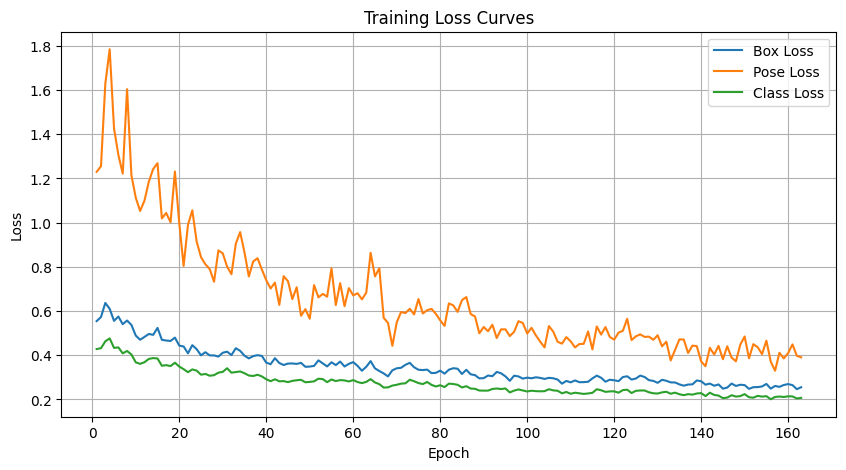

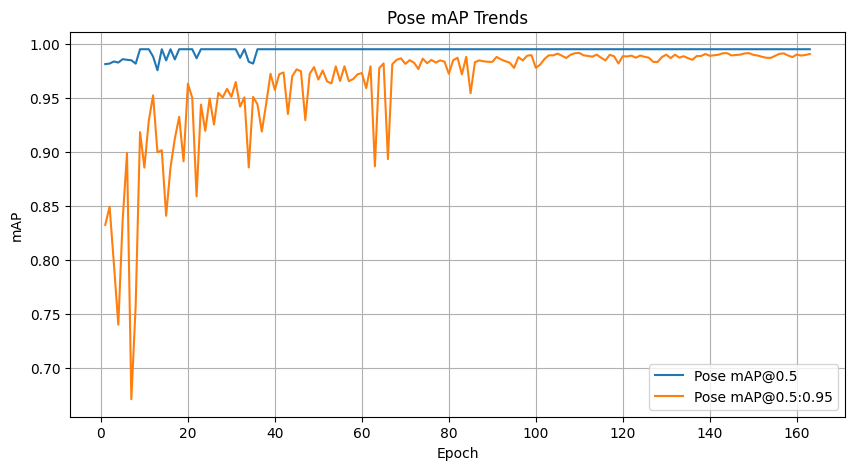

In [ ]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
plt.plot(df["epoch"], df["train/pose_loss"], label="Pose Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP Trends
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["metrics/mAP50(P)"], label="Pose mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(P)"], label="Pose mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Pose mAP Trends")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load the best fine-tuned model
model = YOLO("/content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/weights/best.pt")

# Run inference on a test video or image
results = model.predict(
    source="/content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val",
    conf=0.05,  # Confidence threshold to suppress low-quality predictions
    iou=0.4,   # NMS IoU threshold
    save=True, # Save annotated results
    show=True  # Show visualizations directly in Colab/Notebook
)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_11_frame_333.jpg: 384x640 1 class_0, 90.6ms
image 2/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_11_frame_499.jpg: 384x640 1 class_0, 17.5ms
image 3/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_11_frame_832.jpg: 384x640 1 class_0, 13.4ms
image 4/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_11_frame_999.jpg: 384x640 1 class_0, 13.1ms
image 5/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_12_frame_333.jpg: 384x640 1 class_0, 13.3ms
image 6/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_12_frame_499.jpg: 384x640 1 class_0, 13.7ms
image 7/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_13_frame_832.jpg: 384x640 1 class_0, 15.3ms
image 8/91 /content/drive/MyDrive/NeuroKinematic Analyzer/data/images/val/C1_1

# Fine Tuned vs. Pre-trained

In [ ]:
from ultralytics import YOLO

# Evaluate pretrained model
model_pre = YOLO('/content/yolo11n-pose.pt')
metrics_pre = model_pre.val(data=DATA_YAML)

# Evaluate fine-tuned model
model_ft = YOLO('/content/drive/MyDrive/NeuroKinematic Analyzer/runs/pose/train/train/weights/best.pt')
metrics_ft = model_ft.val(data=DATA_YAML)

# Print/compare metrics
print("Pretrained:")
print(metrics_pre)
print("Fine-tuned:")
print(metrics_ft)


100%|██████████| 5.97M/5.97M [00:00<00:00, 153MB/s]

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 104.3±15.5 MB/s, size: 239.6 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


                   all         91         91      0.999          1      0.995      0.961      0.999          1      0.995      0.989
Speed: 4.6ms preprocess, 9.7ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/pose/val
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-pose summary (fused): 109 layers, 2,866,468 parameters, 0 gradients, 7.4 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 107.0±21.2 MB/s, size: 239.7 KB)


val: Scanning /content/drive/MyDrive/NeuroKinematic Analyzer/data/labels/val.cache... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


                   all         91         91      0.999          1      0.995      0.985      0.999          1      0.995      0.991
Speed: 3.5ms preprocess, 4.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/pose/val2
Pretrained:
ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9ff1001a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022

In [ ]:
import shutil

# Source (local in Colab)
src_folder = "/content/runs"

# Destination in Drive
dst_folder = "/content/drive/MyDrive/NeuroKinematic Analyzer/validation_runs"

# Move the folder
shutil.move(src_folder, dst_folder)


'/content/drive/MyDrive/NeuroKinematic Analyzer/validation_runs'